# Notebook: Estudo da variação do hop para sinais com e sem ruído

Descrição:

Neste notebook apresenta-se os resultados do estudo da variação do hop para sinais com e sem ruído. Sinais simulados são utilizados para gerar espectrogramas (Seção 1.0) que são observados juntamente com métricas quantitativas que auxiliam na caracterização do espectrograma com relação a variação do hop.

Como resultados principais (Seção 2.0) caracteriza-se a perda da resolução temporal em função do hop, as mudanças visuais observadas no espectrograma, a influência do hop nas listras dos picos do espectrograma e o impacto (insignificante) do hop na resolução frequencial dos picos mais relevantes do espectrograma.

Apresenta-se ainda resultados extras relacionados a uma metodologia de segmentação do espectrograma. Essa segmentação é utilizada para derivar características estatísticas que variam em função do hop em diferentes partes da imagem (Seção 3.0).


## 0.0 Definições

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_param_study as funcstud

## 1.0 Aquisição dos sinais simulados, geração dos espectrogramas e carregamento das métricas quantitativas:

In [3]:
qntty = 100
test_not_save = True

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [6]:
corrupted_fids = utils.create_corrupted_fids(gt=gt_fids,t=t,std_base=6,std_var=2,ntransients=160)

In [7]:
mfft_ = 512
window_ = hann(mfft_,sym=True)
hop_ = np.arange(2,128,2).astype('int')
norm_ = 'abs'
spgram_hop_gt = {}
spgram_hop_ns = {}
for i in range(hop_.shape[0]):
    spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_,mfft=mfft_,hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop_gt['hop_'+str(hop_[i])] = [spgram_gt, freq_spect, ppm_spect, t_spect]
    spgram_ns, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:],axis=2),bandwidth=bandwidth,window=window_,mfft=mfft_,hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop_ns['hop_'+str(hop_[i])] = [spgram_ns, freq_spect, ppm_spect, t_spect]

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [8]:
list_of_t_spects = []
list_of_ppm_spects = []
for i in range(hop_.shape[0]):
    list_of_t_spects.append(spgram_hop_gt['hop_'+str(hop_[i])][-1])
    list_of_ppm_spects.append(spgram_hop_gt['hop_'+str(hop_[i])][2])
idx_time_0d05 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05)
idx_time_0d4 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4)
idx_time_0d6 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6)
idx_freq_0ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0)
idx_freq_1ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1)
idx_freq_4ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4)
idx_freq_8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8)
idx_freq_8d5ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5)
idx_freq_NAA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02)
idx_freq_GABA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00)
idx_freq_Glx = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75)

### 1.1 Carregamento das Métricas Quantitativas

In [10]:
gt_metrics = utils.read_txt_file_wth_qnttive_metrics('./quantitative_metrics_saved_data/quantitative_metrics_no_noise_hop_variation_mfft_512.txt')
ns_metrics = utils.read_txt_file_wth_qnttive_metrics('./quantitative_metrics_saved_data/quantitative_metrics_with_noise_hop_variation_mfft_512.txt')

In [11]:
metrics_names = list(gt_metrics.keys())

## 2.0 Resultados Principais

### 2.1 Perda da resolução temporal do espectrograma

O número de colunas do espectrograma cai consideravelmente conforme o hop aumenta. Queda não linear.

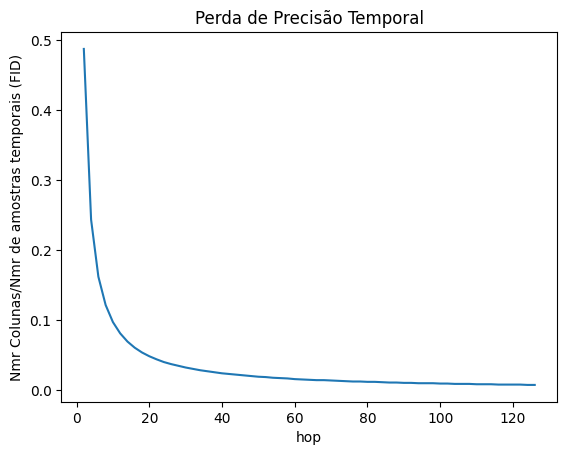

In [12]:
info_concentration = []
for i in range(len(hop_)):
    info_concentration.append(spgram_hop_gt['hop_'+str(hop_[i])][0].shape[2]/gt_fids.shape[1])

plt.plot(hop_,info_concentration)
plt.ylabel('Nmr Colunas/Nmr de amostras temporais (FID)')
plt.xlabel('hop')
plt.title('Perda de Precisão Temporal')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_hop/spgram_varying_hop_gt_and_noisy_loss_time_precision.png')

### 2.2 Visualização de espectrogramas com diferentes hops:

Imagens sem ruído: Notam-se mudanças nas listras dos picos e na quantidade (e frequência) dos picos de menor intensidade.

Imagens com ruído: O mesmo pode ser dito das litras, mas ao invés de mudar os picos menos intensos, observa-se mudança na quantidadede de faixas de ondulações geradas pelo ruído, essas faixas de ondulação parecem mais frequentes, de forma que olhando todas as imagens com a mesma largura, o padrão "oscilatório" formado pelo ruído parece mudar (quadrado turquesa).

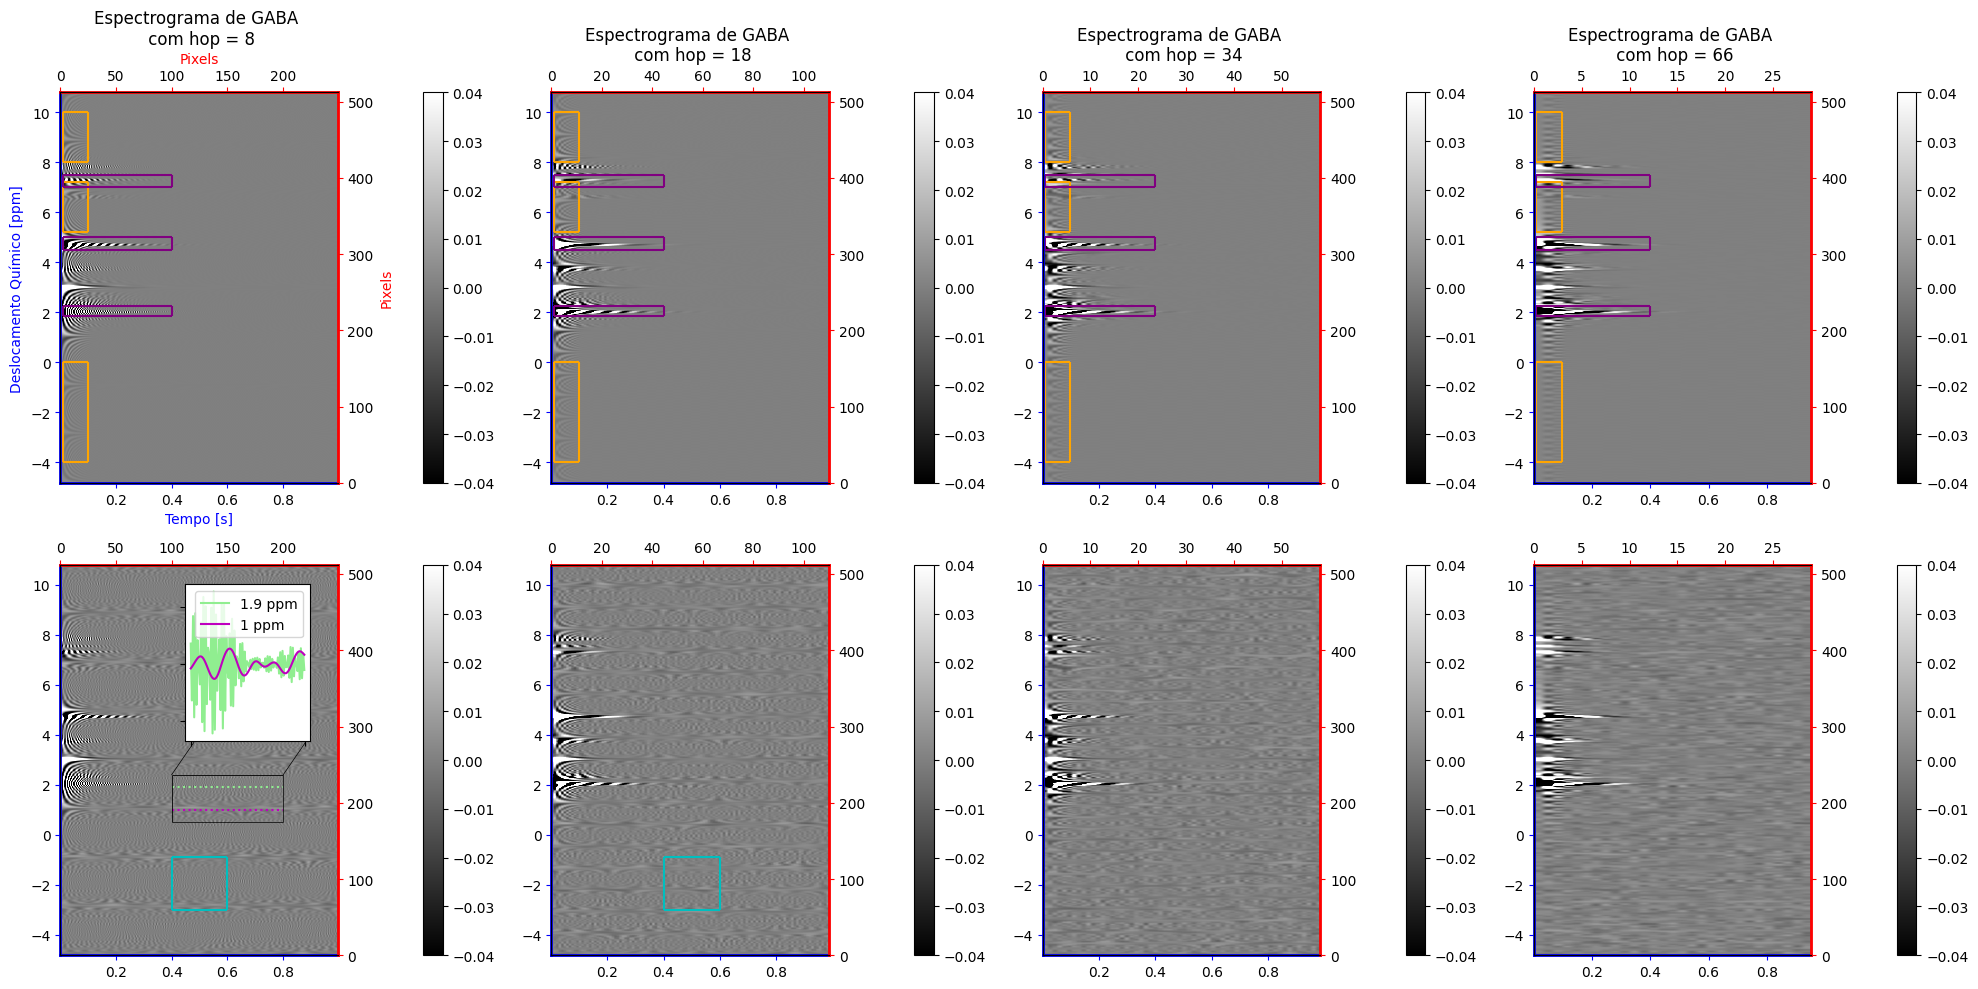

In [13]:
fig,ax = plt.subplots(2,4,figsize=(20,10))
im = ax.flat[0].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[3])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[3])][-1][0],spgram_hop_gt['hop_'+str(hop_[3])][-1][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][0]))
im = ax.flat[1].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[8])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[8])][-1][0],spgram_hop_gt['hop_'+str(hop_[8])][-1][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][0]))
im = ax.flat[2].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[16])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[16])][-1][0],spgram_hop_gt['hop_'+str(hop_[16])][-1][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][0]))
im = ax.flat[3].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[32])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[32])][-1][0],spgram_hop_gt['hop_'+str(hop_[32])][-1][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][0]))
im =ax.flat[4].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[3])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[3])][-1][0],spgram_hop_gt['hop_'+str(hop_[3])][-1][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][0]))
im =ax.flat[5].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[8])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[8])][-1][0],spgram_hop_gt['hop_'+str(hop_[8])][-1][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][0]))
im = ax.flat[6].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[16])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[16])][-1][0],spgram_hop_gt['hop_'+str(hop_[16])][-1][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][0]))
im = ax.flat[7].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[32])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[32])][-1][0],spgram_hop_gt['hop_'+str(hop_[32])][-1][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][0]))

hop_plot = [3,8,16,32,3,8,16,32]
for i in range(2):
    for j in range(4):
        fig.colorbar(im, ax=ax[i,j], pad = 0.2)
for i in range(8):
    par1 = ax.flat[i].twiny()  # Additional x-axis
    par2 = ax.flat[i].twinx()  # Additional y-axis
    if i < 4:
        ax.flat[i].set_title('Espectrograma de GABA \n com hop = '+str(hop_[hop_plot[i]]))
    if  i == 0:
        ax.flat[i].set_xlabel('Tempo [s]')
        ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
        ax.flat[i].xaxis.label.set_color('b')
        ax.flat[i].yaxis.label.set_color('b')
    ax.flat[i].spines['left'].set_visible(True)
    ax.flat[i].spines['bottom'].set_visible(True)
    ax.flat[i].spines['left'].set_color('b')
    ax.flat[i].spines['bottom'].set_color('b')
    ax.flat[i].spines['left'].set_linewidth(2)
    ax.flat[i].spines['bottom'].set_linewidth(2)
    # Set the position of the additional axes
    par1.spines['top'].set_position(('axes', 1))
    par2.spines['right'].set_position(('axes', 1))
    # Customize the additional axes
    par1.set_xlim(0,spgram_hop_gt['hop_'+str(hop_[hop_plot[i]])][0].shape[2])
    par2.set_ylim(0,spgram_hop_gt['hop_'+str(hop_[hop_plot[i]])][0].shape[1])
    if i == 0:
        par1.set_xlabel("Pixels")
        par2.set_ylabel("Pixels")
        par1.xaxis.label.set_color('r')
        par2.yaxis.label.set_color('r')
    # Turn off unwanted spines for clarity
    par1.spines['top'].set_visible(True)
    par2.spines['right'].set_visible(True)
    par2.spines['right'].set_color('r')
    par1.spines['top'].set_color('r')
    par2.spines['right'].set_linewidth(2)
    par1.spines['top'].set_linewidth(2)
    # Synchronize the tick positions of the host and the twin axes
    ax.flat[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False,color='b')
    par1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True,color ='r')
    ax.flat[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False,color='b')
    par2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True,color='r')

for i in range(4):
    #less intense peaks
    ax.flat[i].hlines(-4,0.01,0.1,color='orange')
    ax.flat[i].hlines(0,0.01,0.1,color='orange')
    ax.flat[i].vlines(0.01,-4,0,color='orange')
    ax.flat[i].vlines(0.1,-4,0,color='orange')
    ax.flat[i].hlines(5.2,0.01,0.1,color='orange')
    ax.flat[i].hlines(7.2,0.01,0.1,color='orange')
    ax.flat[i].vlines(0.01,5.2,7.2,color='orange')
    ax.flat[i].vlines(0.1,5.2,7.2,color='orange')
    ax.flat[i].hlines(8,0.01,0.1,color='orange')
    ax.flat[i].hlines(10,0.01,0.1,color='orange')
    ax.flat[i].vlines(0.01,8,10,color='orange')
    ax.flat[i].vlines(0.1,8,10,color='orange')
    #stripes
    ax.flat[i].hlines(1.85,0.01,0.4,color='purple')
    ax.flat[i].hlines(2.25,0.01,0.4,color='purple')
    ax.flat[i].vlines(0.01,1.85,2.25,color='purple')
    ax.flat[i].vlines(0.4,1.85,2.25,color='purple')
    ax.flat[i].hlines(4.50,0.01,0.4,color='purple')
    ax.flat[i].hlines(5,0.01,0.4,color='purple')
    ax.flat[i].vlines(0.01,4.50,5,color='purple')
    ax.flat[i].vlines(0.4,4.50,5,color='purple')
    ax.flat[i].hlines(7,0.01,0.4,color='purple')
    ax.flat[i].hlines(7.5,0.01,0.4,color='purple')
    ax.flat[i].vlines(0.01,7,7.5,color='purple')
    ax.flat[i].vlines(0.4,7,7.5,color='purple')
#noise regions
axins1 = ax.flat[4].inset_axes([0.45, 0.55, 0.45, 0.4], xticklabels=[], yticklabels=[])
axins1.plot(np.real(spgram_hop_ns['hop_'+str(hop_[3])][0][0,220,100:200]),color='lightgreen',label='1.9 ppm')
axins1.plot(np.real(spgram_hop_ns['hop_'+str(hop_[3])][0][0,190,100:200]),color='m', label='1 ppm')
axins1.legend(loc='upper right')
ax.flat[4].hlines(1,0.4,0.8,color='m',linestyle='dotted')
ax.flat[4].hlines(1.9,0.4,0.8,color='lightgreen',linestyle='dotted')
ax.flat[4].hlines(0.5,0.4,0.8,color='black',linewidth=0.5)
ax.flat[4].hlines(2.4,0.4,0.8,color='black',linewidth=0.6)
ax.flat[4].vlines(0.4,0.5,2.4,color='black',linewidth=0.6)
ax.flat[4].vlines(0.8,0.5,2.4,color='black',linewidth=0.5)
ax.flat[4].plot([0.4,0.48],[2.4,3.7],color='black',linewidth=0.5)
ax.flat[4].plot([0.8,0.88],[2.4,3.7],color='black',linewidth=0.5)
for i in range(2):
    ax.flat[4+i].hlines(-3,0.4,0.6,color='c')
    ax.flat[4+i].hlines(-0.9,0.4,0.6,color='c')
    ax.flat[4+i].vlines(0.4,-3,-0.9,color='c')
    ax.flat[4+i].vlines(0.6,-3,-0.9,color='c')


plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_hop/spgram_varying_hop_gt_and_noisy_image_examples.png')

Espectrogramas concatenados:

Olhando mais de perto, fica visível que existe realmente uma diferença na quantidade e formato das listras de cada imagem. A questão dos picos menos intensos e faixas de ruído também é visível quando se olha a parte real do espectrograma. O pico de GABA parece se manter sempre branco com um envoltório preto. Essa observação será discutida com mais detalhes com o auxílio da métrica ZCR.


A base dos picos é interconectada, i.e., é difícil delimitar a região de cada pico. Com o aumento do hop e a mudança da frequência dos picos menos significativos, tem-se a impressão que cada pico está associado a um bloco de frequências cuja extensão parece diminuir com o aumento do hop. Essa impressão fica mais acentuada quando observa-se o valor absoluto da parte real do espectrograma, onde, devido ao nível de contraste utilizado, nota-se linhas pretas separando tais blocos de frequência (em branco). Tais modificações sugerem mudanças na resolução frequencial da imagem. Devido aos diferentes padrões de listras de cada imagem é difícil concluir visualmente se existe um impacto na resolução frequencial dos picos relevante, i.e., que trazem informações sobre a composição química da região cerebral amostrada. Dessa forma, esse estudo se apoia no uso da métrica FWHM, que é discutida posteriormente.

In [14]:
aux_concat = (np.arange(4,len(hop_),6)).tolist()
spgram_hop_concat_gt = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_gt,list_time_idx=idx_time_0d4,fid_idx_plot=0)
spgram_hop_concat_ns = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_ns,list_time_idx=idx_time_0d4,fid_idx_plot=0)

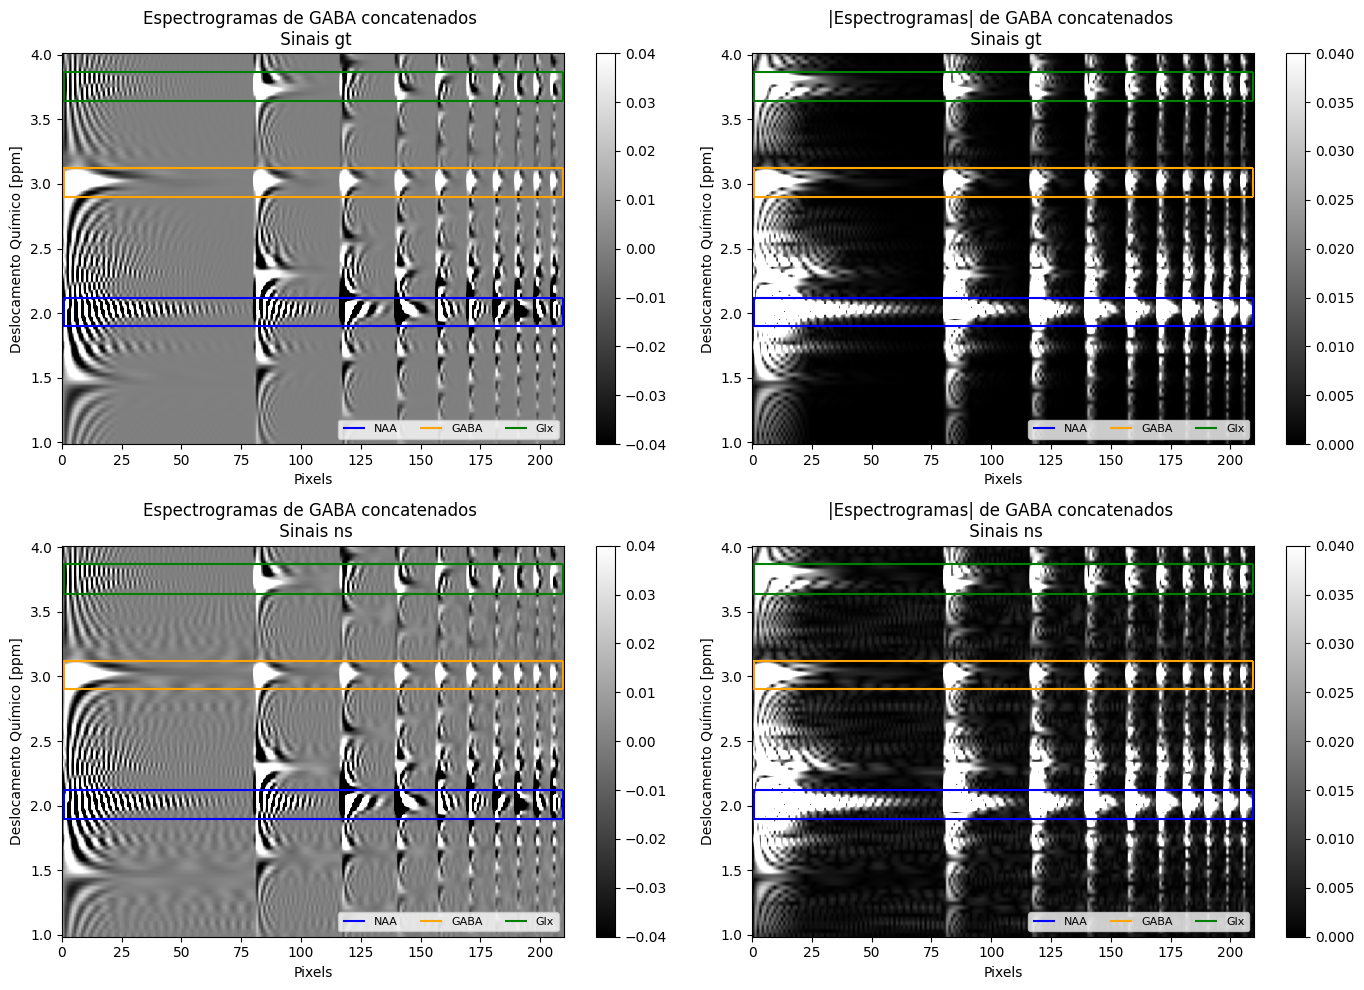

In [15]:
fig,ax = plt.subplots(2,2,figsize=(14,10))
im = ax[0,0].imshow(np.real(spgram_hop_concat_gt[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_gt.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Espectrogramas de GABA concatenados \n Sinais gt')
im = ax[0,1].imshow(np.abs(np.real(spgram_hop_concat_gt[idx_freq_1ppm[0]:idx_freq_4ppm[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat_gt.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('|Espectrogramas| de GABA concatenados \n Sinais gt')
im = ax[1,0].imshow(np.real(spgram_hop_concat_ns[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_ns.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[1,0])
ax[1,0].set_title('Espectrogramas de GABA concatenados \n Sinais ns')
im = ax[1,1].imshow(np.abs(np.real(spgram_hop_concat_ns[idx_freq_1ppm[0]:idx_freq_4ppm[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat_ns.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[1,1])
ax[1,1].set_title('|Espectrogramas| de GABA concatenados \n Sinais ns')

for i in range(4):
    ax.flat[i].hlines(1.90,0.005,209.5,color='b',label='NAA')
    ax.flat[i].hlines(2.12,0.005,209.5,color='b')
    ax.flat[i].vlines(1,1.90,2.12,color='b')
    ax.flat[i].vlines(209.5,1.90,2.12,color='b')
    ax.flat[i].hlines(2.90,0.005,209.5,color='orange',label='GABA')
    ax.flat[i].hlines(3.12,0.005,209.5,color='orange')
    ax.flat[i].vlines(1,2.90,3.12,color='orange')
    ax.flat[i].vlines(209.5,2.90,3.12,color='orange')
    ax.flat[i].hlines(3.87,0.005,209.5,color='g',label='Glx')
    ax.flat[i].hlines(3.64,0.005,209.5,color='g')
    ax.flat[i].vlines(1,3.64,3.87,color='g')
    ax.flat[i].vlines(209.5,3.64,3.87,color='g')
    ax.flat[i].legend(loc='lower right',ncols=3,fontsize=8)
    ax.flat[i].set_xlabel('Pixels')
    ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_hop/spgram_varying_hop_gt_and_noisy_concatenated_image.png')

### 2.3 O padrão de listras das imagens muda com hop?

A taxa de cruzamento com zero (ZCR) coincide para espectrogramas gerados de sinais gt e ns. Com o aumento do hop, o número de colunas da imagem muda, desse modo, mesmo que visualmente o pico de GABA seja sempre branco, com um envoltório preto, o ZCR do GABA muda com o hop. Ele aumenta pois um cruzamento se torna uma taxa maior a medida que o denominador diminui. 

Para os picos de NAA e Glx, tanto o numerador quanto o denominador da razão mudam ao mesmo tempo, e o que se observa é que o ZCR do NAA varia de modo que dois máximos estão distantes em média de 14 unidades de hop. Nos dois exemplos mostrados, observa-se como a quantidade de listras diminui e aumenta de novo. Já o comportamento das listras em Glx não é tão bem definido. O pico de Glx é formado pela combinação de um pico em 3,7 ppm e outro em 3,8 ppm, visualmente, parece que o pico em torno de 3,8 ppm varia mais rápido que o em torno de 3,7 ppm - a quantidade de listras decresce mais rápido, nos exemplos visualizados e depois volta a aumentar antes do pico em torno de 3,7 ppm.  Apesar do comportamento do Glx não ser tão bem definido, notam-se alguns padrões repetitivos, por exemplo, o padrão de Glx quando hop igual a 16, 18 e 20 é muito similar ao obtido com hop igual a 36, 38 e 40.

Finalmente, o perfil dos picos complementam a análise visual. O perfil da linha do GABA mostra apenas um cruzamento com zero. O perfil da linha do NAA mostra um número mínimo de cruzamentos para hop = 16 no intervalo considerado. Já o perfil da linha do Glx apresenta uma quantidade menor de cruzamentos para hop = 20, coerente com o espectrograma visualizado.

In [16]:
aux_concat = (np.arange(3,12)).tolist()
spgram_hop_concat_for_zcr_1 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_gt,list_time_idx=idx_time_0d4,fid_idx_plot=0)
aux_concat = (np.arange(11,20)).tolist()
spgram_hop_concat_for_zcr_2 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_gt,list_time_idx=idx_time_0d4,fid_idx_plot=0)

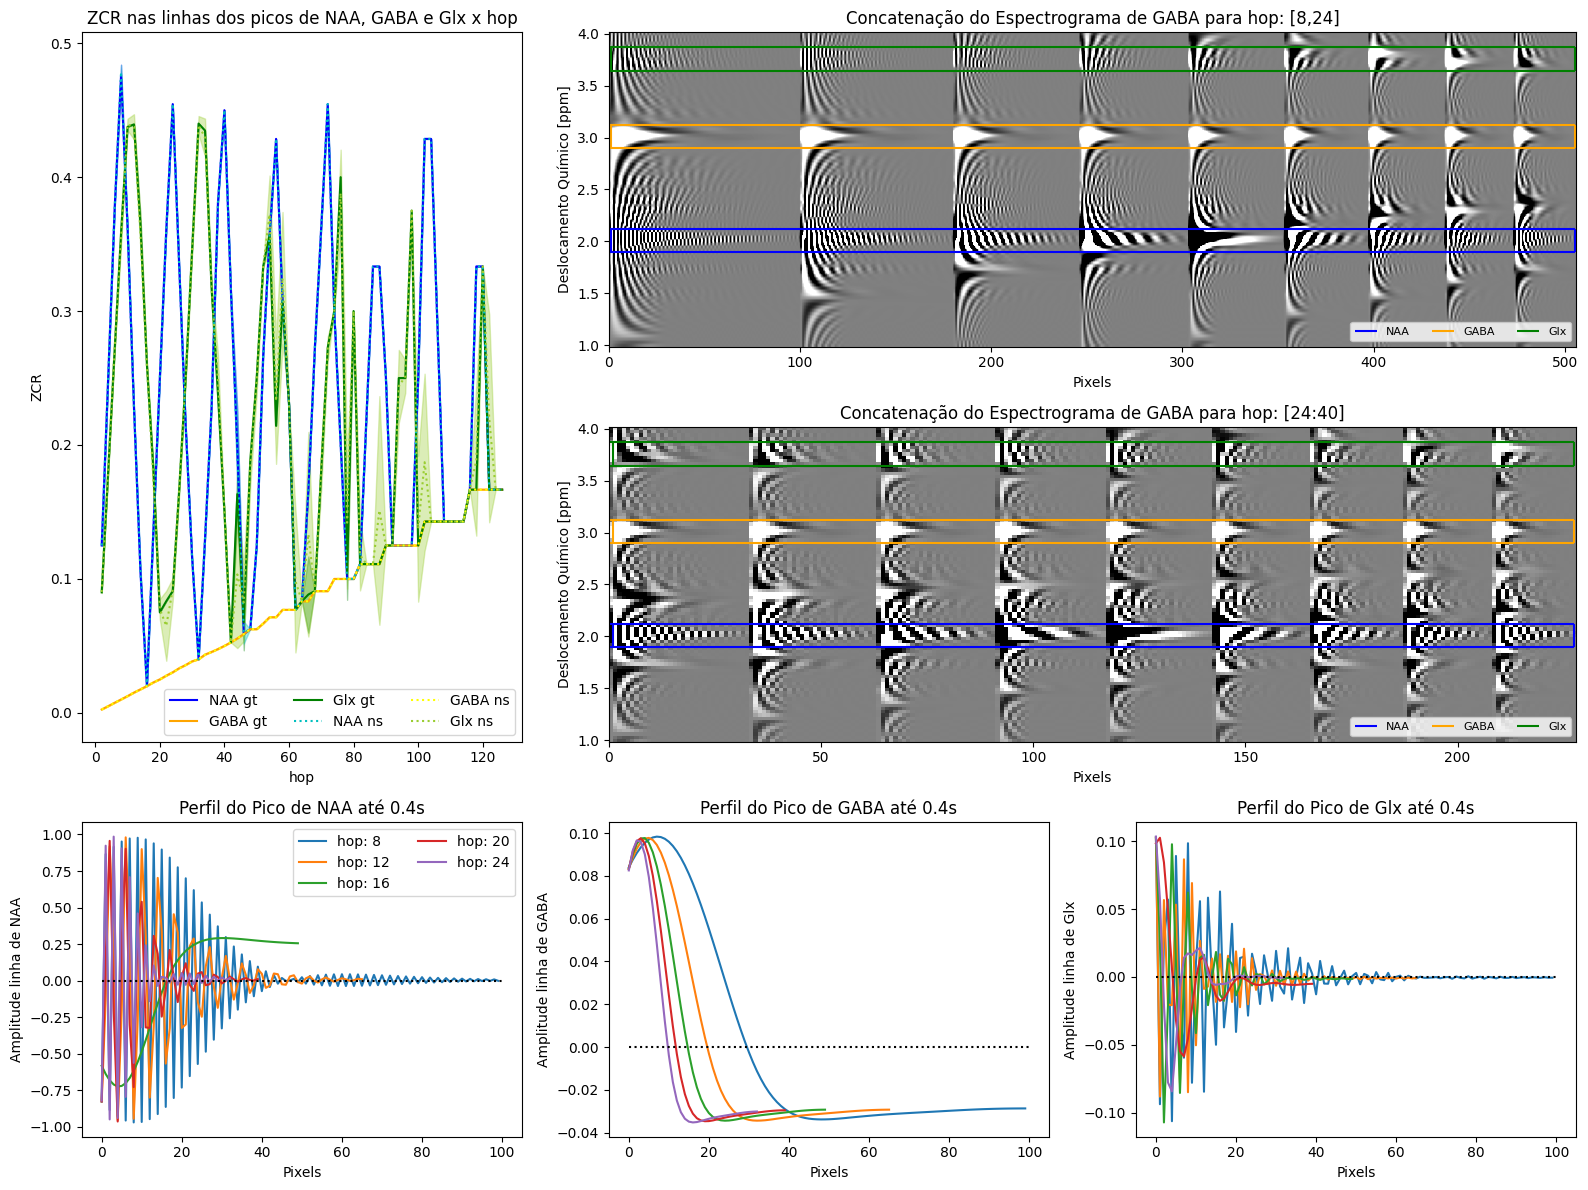

In [17]:
from matplotlib.gridspec import GridSpec
# Create figure and GridSpec
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0:2, 0])  
ax2 = fig.add_subplot(gs[0, 1:]) 
#ax3 = fig.add_subplot(gs[1, 0])  
#ax3.axis('off')
ax4 = fig.add_subplot(gs[1, 1:]) 
ax5 = fig.add_subplot(gs[2, 0])    
ax6 = fig.add_subplot(gs[2, 1]) 
ax7 = fig.add_subplot(gs[2, 2])

ax1.plot(hop_,gt_metrics['zcr_']['NAA']['mean'],color='b',label='NAA gt')
ax1.fill_between(hop_, np.array(gt_metrics['zcr_']['NAA']['mean']) - np.array(gt_metrics['zcr_']['NAA']['std']), 
                        np.array(gt_metrics['zcr_']['NAA']['mean']) + np.array(gt_metrics['zcr_']['NAA']['std']), alpha=0.35, color = 'b')
ax1.plot(hop_,gt_metrics['zcr_']['GABA']['mean'],color='orange',label='GABA gt')
ax1.fill_between(hop_, np.array(gt_metrics['zcr_']['GABA']['mean']) - np.array(gt_metrics['zcr_']['GABA']['std']), 
                        np.array(gt_metrics['zcr_']['GABA']['mean']) + np.array(gt_metrics['zcr_']['GABA']['std']), alpha=0.35, color = 'orange')
ax1.plot(hop_,gt_metrics['zcr_']['Glx']['mean'],color='g',label='Glx gt')
ax1.fill_between(hop_, np.array(gt_metrics['zcr_']['Glx']['mean']) - np.array(gt_metrics['zcr_']['Glx']['std']), 
                        np.array(gt_metrics['zcr_']['Glx']['mean']) + np.array(gt_metrics['zcr_']['Glx']['std']), alpha=0.35, color = 'g')
ax1.plot(hop_,ns_metrics['zcr_']['NAA']['mean'],color='c',label='NAA ns',linestyle='dotted')
ax1.fill_between(hop_, np.array(ns_metrics['zcr_']['NAA']['mean']) - np.array(ns_metrics['zcr_']['NAA']['std']), 
                        np.array(ns_metrics['zcr_']['NAA']['mean']) + np.array(ns_metrics['zcr_']['NAA']['std']), alpha=0.35, color = 'c')
ax1.plot(hop_,ns_metrics['zcr_']['GABA']['mean'],color='yellow',label='GABA ns',linestyle='dotted')
ax1.fill_between(hop_, np.array(ns_metrics['zcr_']['GABA']['mean']) - np.array(ns_metrics['zcr_']['GABA']['std']), 
                        np.array(ns_metrics['zcr_']['GABA']['mean']) + np.array(ns_metrics['zcr_']['GABA']['std']), alpha=0.35, color = 'yellow')
ax1.plot(hop_,ns_metrics['zcr_']['Glx']['mean'],color='yellowgreen',label='Glx ns',linestyle='dotted')
ax1.fill_between(hop_, np.array(ns_metrics['zcr_']['Glx']['mean']) - np.array(ns_metrics['zcr_']['Glx']['std']), 
                        np.array(ns_metrics['zcr_']['Glx']['mean']) + np.array(ns_metrics['zcr_']['Glx']['std']), alpha=0.35, color = 'yellowgreen')
ax1.legend(loc='lower right', ncol=3)
ax1.set_title('ZCR nas linhas dos picos de NAA, GABA e Glx x hop')
ax1.set_ylabel('ZCR')
ax1.set_xlabel('hop')
ax1.set_xticks([0,20,40,60,80,100,120])
ax1.set_xticklabels(['0','20','40','60','80','100','120'])


ax2.imshow(np.real(spgram_hop_concat_for_zcr_1[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_1.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax2.set_xlabel('Pixels')
ax2.set_ylabel('Deslocamento Químico [ppm]')
ax2.set_title('Concatenação do Espectrograma de GABA para hop: [8,24]')

ax4.imshow(np.real(spgram_hop_concat_for_zcr_2[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_2.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax4.set_xlabel('Pixels')
ax4.set_ylabel('Deslocamento Químico [ppm]')
ax4.set_title('Concatenação do Espectrograma de GABA para hop: [24:40]')

ax2.hlines(1.90,0.005,505.5,color='b',label='NAA')
ax2.hlines(2.12,0.005,505.5,color='b')
ax2.vlines(1,1.90,2.12,color='b')
ax2.vlines(505.5,1.90,2.12,color='b')
ax2.hlines(2.90,0.005,505.5,color='orange',label='GABA')
ax2.hlines(3.12,0.005,505.5,color='orange')
ax2.vlines(1,2.90,3.12,color='orange')
ax2.vlines(505.5,2.90,3.12,color='orange')
ax2.hlines(3.87,0.005,505.5,color='g',label='Glx')
ax2.hlines(3.64,0.005,505.5,color='g')
ax2.vlines(1,3.64,3.87,color='g')
ax2.vlines(505.5,3.64,3.87,color='g')
ax2.legend(loc='lower right',ncols=3,fontsize=8)

ax4.hlines(1.90,0.005,227.5,color='b',label='NAA')
ax4.hlines(2.12,0.005,227.5,color='b')
ax4.vlines(1,1.90,2.12,color='b')
ax4.vlines(227.5,1.90,2.12,color='b')
ax4.hlines(2.90,0.005,227.5,color='orange',label='GABA')
ax4.hlines(3.12,0.005,227.5,color='orange')
ax4.vlines(1,2.90,3.12,color='orange')
ax4.vlines(227.5,2.90,3.12,color='orange')
ax4.hlines(3.87,0.005,227.5,color='g',label='Glx')
ax4.hlines(3.64,0.005,227.5,color='g')
ax4.vlines(1,3.64,3.87,color='g')
ax4.vlines(227.5,3.64,3.87,color='g')
ax4.legend(loc='lower right',ncols=3,fontsize=8)

for i in range(3,12,2):
    ax5.plot(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][0,idx_freq_NAA[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][:,idx_freq_NAA[i],:idx_time_0d4[i]]),axis=1)[0],label='hop: '+str(hop_[i]))
    ax6.plot(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][0,idx_freq_GABA[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][:,idx_freq_GABA[i],:idx_time_0d4[i]]),axis=1)[0],label='hop: '+str(hop_[i]))
    ax7.plot(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][0,idx_freq_Glx[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][:,idx_freq_Glx[i],:idx_time_0d4[i]]),axis=1)[0],label='hop: '+str(hop_[i]))
ax5.hlines(0,0,100,color='black',linestyle='dotted')
ax6.hlines(0,0,100,color='black',linestyle='dotted')
ax7.hlines(0,0,100,color='black',linestyle='dotted')
ax5.set_title('Perfil do Pico de NAA até 0.4s')
ax5.set_ylabel('Amplitude linha de NAA')
ax5.set_xlabel('Pixels')
ax5.legend(loc='upper right',ncols=2)
ax6.set_title('Perfil do Pico de GABA até 0.4s')
ax6.set_ylabel('Amplitude linha de GABA')
ax6.set_xlabel('Pixels')
ax7.set_title('Perfil do Pico de Glx até 0.4s')
ax7.set_ylabel('Amplitude linha de Glx')
ax7.set_xlabel('Pixels')
plt.subplots_adjust(hspace=0.25) 

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_hop/spgram_varying_hop_gt_and_noisy_zcr.png')

### 2.4 Os picos relevantes mudam de resolução frequencial com o hop?

Para responder essa questão usaremos as projeções no eixo da frequência:

In [18]:
plot_id = [0,29,43,50,59]
list_projections_abs_gt = []
list_projections_real_gt = []
list_projections_abs_ns = []
list_projections_real_ns = []
idx_fwhm_gt = {}
idx_fwhm_real_gt = {}
idx_fwhm_ns = {}
idx_fwhm_real_ns = {}
list_of_ppm_spects = []
idx_freq_NAA_aux = []
idx_freq_GABA_aux = []
idx_freq_Glx_aux = []
for i in range(len(plot_id)):
    list_projections_abs_gt.append(np.sum(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])), axis = 2))
    list_projections_real_gt.append(np.sum(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]), axis = 2))
    list_projections_abs_ns.append(np.sum(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])), axis = 2))
    list_projections_real_ns.append(np.sum(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]), axis = 2))
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])] = {}
    list_of_ppm_spects.append(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])
    idx_freq_NAA_aux.append(idx_freq_NAA[plot_id[i]])
    idx_freq_GABA_aux.append(idx_freq_GABA[plot_id[i]])
    idx_freq_Glx_aux.append(idx_freq_Glx[plot_id[i]])

print('starting gt data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for gt data')
for i in range(len(plot_id)):
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

print('starting ns data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for ns data')
for i in range(len(plot_id)):
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

starting gt data
adjusting for gt data
starting ns data
adjusting for ns data


A questão da mudança frequencial pode ser estudada a partir da FWHM da projeção do espectrograma no eixo das frequências, a qual deveria, de certo modo, corresponder ao espectro do sinal. Tal projeção pode ser feita diretamente com a parte real do espectrograma, a qual corresponder ao espectro de GABA típico, que também considera apenas a parte real da FT, ou também pode ser feita considerando o valor absoluto da parte real. O interesse de utilizar a projeção do valor absoluto é que a mesma para de depender do padrão de listras da imagem. Como o hop altera esse padrão, ao considerar o valor absoluto tem-se a certeza de que os picos do espectrograma serão representados na projeção, pois na projeção simples, se a quantidade de listras pretas e brancas for igual para um determinado pico, sua projeção no eixo da frequência levaria a supressão do pico (assumindo simetria entre a intensidade dos valores positivos e negativos, o que aprece coerente vide perfil dos picos de NAA e Glx).

O que se observa considerando Proj(|Espectrograma|):
- NAA: com exceção de para hop = 120, FWHM constante.
- GABA: para STFT de sinais gt, há uma diminuição da FWHM com o aumento de hop a partir de hop 98, isso é visível observando a posição média das laterais da meia altura, e também notando que, na sobreposição das projeções normalizadas, o traçado azul (hop =2) é externo ao vermelho (hop = 102), que por sua vez é externo ao violeta (hop = 120). Os traçados azul, laranja (hop = 60) e verde (hop = 88) parecem se sobrepor, o que concorda que para valores menores de hop, a largura do pico se mantém. Para sinais ns, dado FWHM, esperaria-se que a largura do pico de GABA diminuisse e depois aumentasse novamente. Visualmente, as projeções médias parecem indicar um comportamento parecido ao notado para sinais gt, o que indica uma sensibilidade da métrica com relação ao ruído. A posição média das laterais da meia altura também indicam uma sensibilidade ao ruído, visto que elas não necessariamente se alinham a impressão visual da posição da meia altura.
- Glx: a métrica FWHM é inconsistente para avaliar a largura desse pico, visto que a variação do hop impacta no formato do pico: para determinados valores o pico em torno de 3.7 ppm é mais alto que o pico em torno de 3.8 ppm, e para outros ocorre o contrário. Essa variação faz com que a FWHM não seja medida sempre com relação ao mesmo pico, o que leva a uma maior variação da métrica. Visualmente, a largura do pico combinado parece diminuir para hops mais elevados, devido aos traçados vermelho e violeta serem interior aos demais próximo da região média.

O que se conclui de Proj(Espectrograma):
- NAA: o formato do pico é impactado pela região ao redor dele, a qual varia bastante com hop, impactando FWHM. Note como nem sempre o pico está alinhado com 2 ppm. Além disso, como no espectro de GABA, o pico de NAA tende a ser negativo.
- GABA: o pico fica bem definido nesse caso, e se torna o maior pico da projeção nesse caso. Dessa forma, a medição de FWHM parece ser bem consistente e indica que a largura do pico não varia com o hop.
- Glx: novamente, o formato do pico varia muito com o hop, de forma ainda mais intensa que para a projeção dos valores absolutos.

Ao que essa análise indica, a menos para valores de hop muito elevados, onde a perda de resolução temporal é muito intensa, o pico de GABA mantém sua resolução frequêncial, para ambas projeções. Considerando a projeção dos valores absolutos, a qual é mais consistente para picos listrados, a largura do pico de NAA se mantém, um comportamento parecido ao do pico de GABA pode ser atribuído ao de Glx, quando considera-se uma inspeção visual. Assim, os picos relevantes da imagem parecem não terem sua resolução frequencial significativamente impactada, mesmo que isso se observe para os picos menos intensos (Seção 2.1). 

Nota-se ainda que a discordância de FWHM medido no pico de GABA para Proj(Espectrograma) e Proj(|Espectrograma|), e as dificuldades em medir FWHM em Glx indicam uma grande sensibilidade da métrica ao formato do pico, o qual é bastante influenciado pelos picos menos intensos vizinhos aos picos relevantes e que variam com o hop. 

Nota-se ainda que, a projeção da parte real da imagem no eixo das frequências deveria corresponder ao espectro de GABA, porém, as características de tal espectro variam muito com a escolha do hop, como nota-se considerando os diferentes formatos que assumem a região do pico de NAA e Glx. É interessante que apesar das variações para tais picos, o pico de GABA se mantém consistente em Proj(Espectrograma) para todo hop, o que condiz com o fato do pico de GABA se manter invariante no espectrograma. Em outras palavras, o pico de GABA é robusto independemente de hop, o que caracteriza uma robustez do espectrograma como representação para os transientes de GABA.

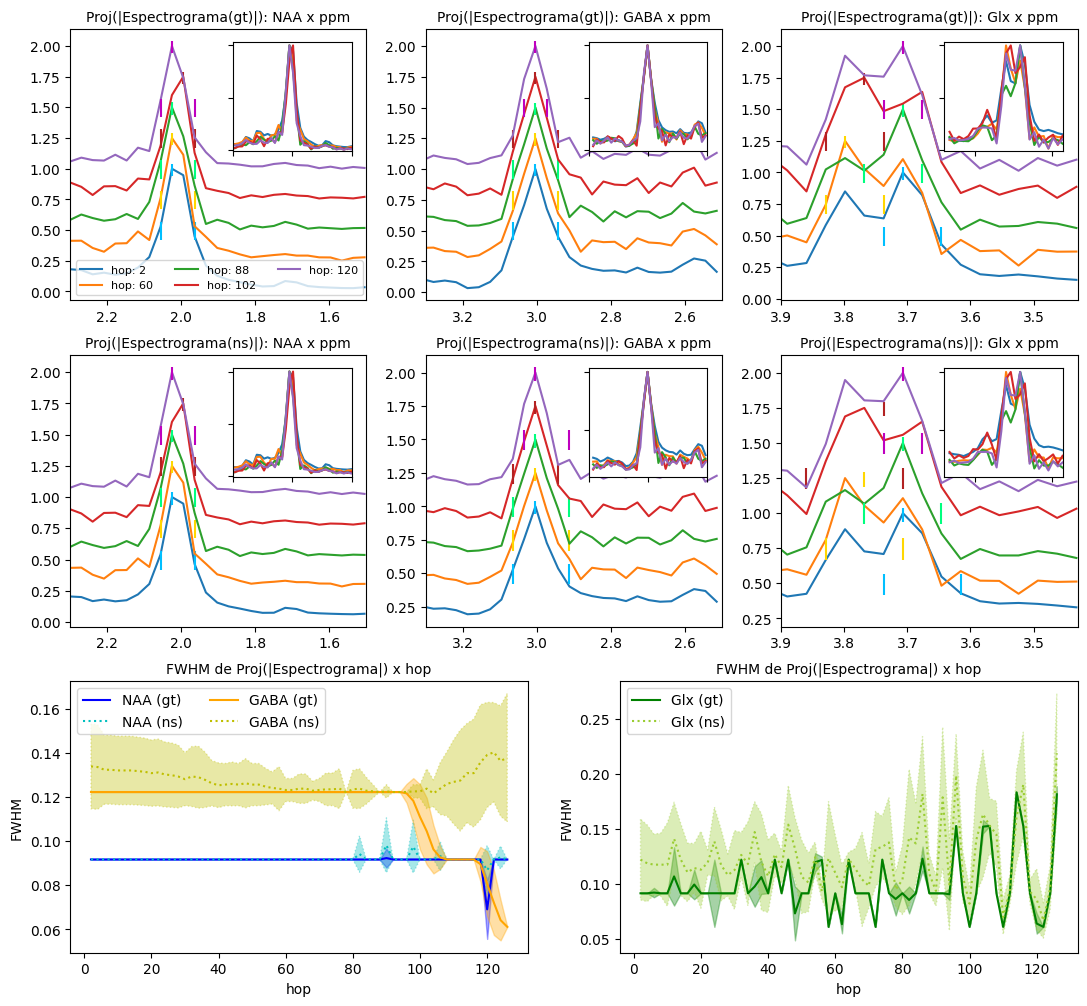

In [19]:
fig = plt.figure(figsize=(13, 12)) 

ax1 = plt.subplot2grid((3, 3), (0, 0))  
ax2 = plt.subplot2grid((3, 3), (0, 1))  
ax3 = plt.subplot2grid((3, 3), (0, 2)) 
ax6 = plt.subplot2grid((3, 3), (1, 0))  
ax7 = plt.subplot2grid((3, 3), (1, 1))  
ax8 = plt.subplot2grid((3, 3), (1, 2)) 

ax4 = plt.subplot2grid((3, 2), (2, 0)) 
ax5 = plt.subplot2grid((3, 2), (2, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])

#plot_id = np.arange(0,len(hop_),10)
plot_id = [0,29,43,50,59]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux = np.mean((np.sum(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])),axis=2)),axis=0)
    aux_ns = np.mean((np.sum(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])),axis=2)),axis=0)
    aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5]),color=colors[i])
    axins6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5]),color=colors[i])
    axins2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5]),color=colors[i])
    axins7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5]),color=colors[i])
    axins3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2]),color=colors[i])
    axins8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2]),color=colors[i])
    aux_NAA = np.mean(idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])


ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower left', ncols=3,fontsize=8)
#ax2.legend(loc='upper left')
#ax3.legend(loc='upper left')
ax1.set_title('Proj(|Espectrograma(gt)|): NAA x ppm',fontsize = 10)
ax2.set_title('Proj(|Espectrograma(gt)|): GABA x ppm',fontsize = 10)
ax3.set_title('Proj(|Espectrograma(gt)|): Glx x ppm',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
#ax6.legend(loc='upper left')
#ax7.legend(loc='upper left')
#ax8.legend(loc='upper left')
ax6.set_title('Proj(|Espectrograma(ns)|): NAA x ppm',fontsize = 10)
ax7.set_title('Proj(|Espectrograma(ns)|): GABA x ppm',fontsize = 10)
ax8.set_title('Proj(|Espectrograma(ns)|): Glx x ppm',fontsize = 10)


ax4.plot(hop_,gt_metrics['fwhm_hop']['NAA']['mean'],label='NAA (gt)',color='b')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop']['NAA']['mean']) - np.array(gt_metrics['fwhm_hop']['NAA']['std']), 
                        np.array(gt_metrics['fwhm_hop']['NAA']['mean']) + np.array(gt_metrics['fwhm_hop']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(hop_,ns_metrics['fwhm_hop']['NAA']['mean'],label='NAA (ns)',color='c',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop']['NAA']['mean']) - np.array(ns_metrics['fwhm_hop']['NAA']['std']), 
                        np.array(ns_metrics['fwhm_hop']['NAA']['mean']) + np.array(ns_metrics['fwhm_hop']['NAA']['std']), alpha=0.35, color = 'c',linestyle='dotted')
ax4.plot(hop_,gt_metrics['fwhm_hop']['GABA']['mean'],label='GABA (gt)',color='orange')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop']['GABA']['mean']) - np.array(gt_metrics['fwhm_hop']['GABA']['std']), 
                        np.array(gt_metrics['fwhm_hop']['GABA']['mean']) + np.array(gt_metrics['fwhm_hop']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(hop_,ns_metrics['fwhm_hop']['GABA']['mean'],label='GABA (ns)',color='y',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop']['GABA']['mean']) - np.array(ns_metrics['fwhm_hop']['GABA']['std']), 
                        np.array(ns_metrics['fwhm_hop']['GABA']['mean']) + np.array(ns_metrics['fwhm_hop']['GABA']['std']), alpha=0.35, color = 'y',linestyle='dotted')
ax4.set_title('FWHM de Proj(|Espectrograma|) x hop',fontsize = 10)
ax4.set_xlabel('hop',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2)
ax5.plot(hop_,gt_metrics['fwhm_hop']['Glx']['mean'],label='Glx (gt)',color='g')
ax5.fill_between(hop_, np.array(gt_metrics['fwhm_hop']['Glx']['mean']) - np.array(gt_metrics['fwhm_hop']['Glx']['std']), 
                    np.array(gt_metrics['fwhm_hop']['Glx']['mean']) + np.array(gt_metrics['fwhm_hop']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(hop_,ns_metrics['fwhm_hop']['Glx']['mean'],label='Glx (ns)',color='yellowgreen',linestyle='dotted')
ax5.fill_between(hop_, np.array(ns_metrics['fwhm_hop']['Glx']['mean']) - np.array(ns_metrics['fwhm_hop']['Glx']['std']), 
                    np.array(ns_metrics['fwhm_hop']['Glx']['mean']) + np.array(ns_metrics['fwhm_hop']['Glx']['std']), alpha=0.35, color = 'yellowgreen',linestyle='dotted')
ax5.set_title('FWHM de Proj(|Espectrograma|) x hop',fontsize = 10)
ax5.set_xlabel('hop',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_hop/spgram_varying_hop_gt_and_noisy_fwhm_abs.png')

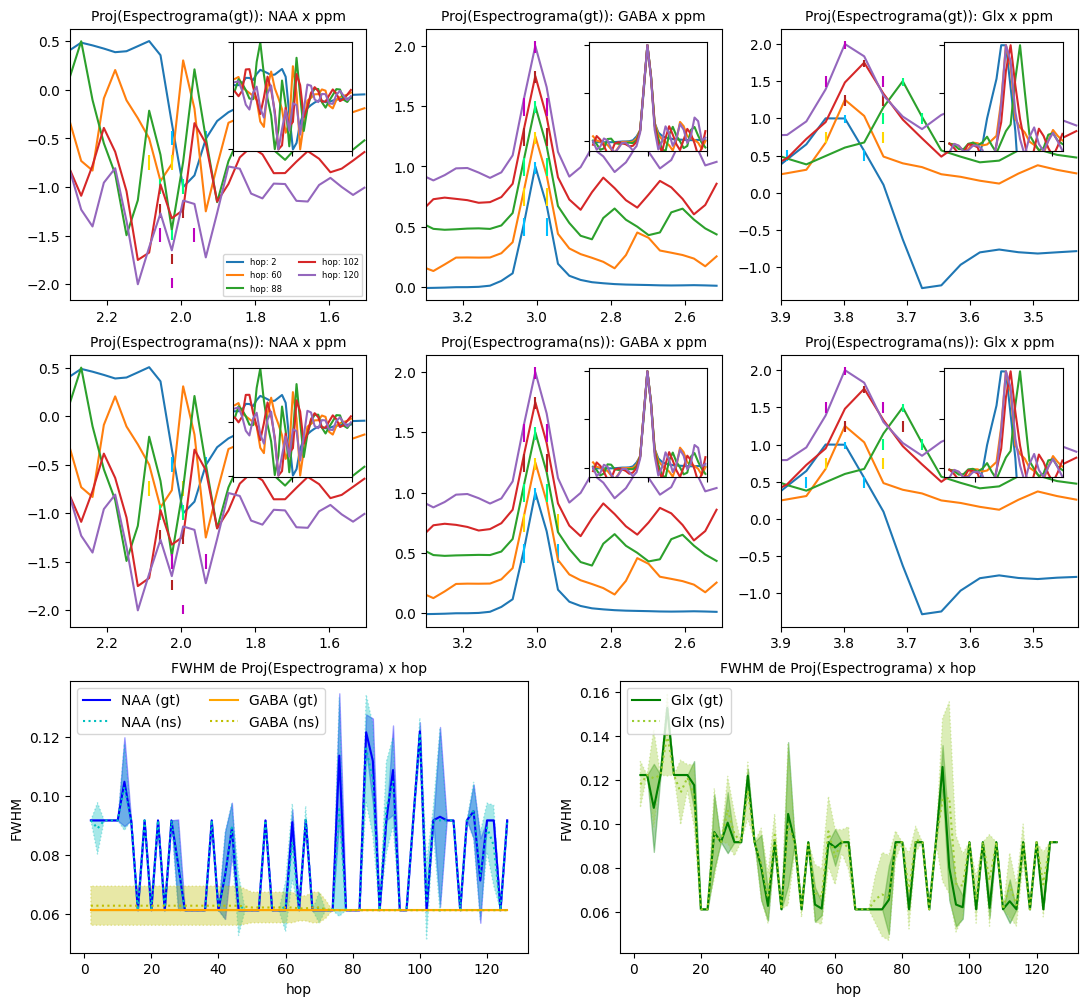

In [20]:
fig = plt.figure(figsize=(13, 12)) 

ax1 = plt.subplot2grid((3, 3), (0, 0))  
ax2 = plt.subplot2grid((3, 3), (0, 1))  
ax3 = plt.subplot2grid((3, 3), (0, 2)) 
ax6 = plt.subplot2grid((3, 3), (1, 0))  
ax7 = plt.subplot2grid((3, 3), (1, 1))  
ax8 = plt.subplot2grid((3, 3), (1, 2)) 

ax4 = plt.subplot2grid((3, 2), (2, 0)) 
ax5 = plt.subplot2grid((3, 2), (2, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])

#plot_id = np.arange(0,len(hop_),10)
plot_id = [0,29,43,50,59]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux = np.mean((np.sum(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]),axis=2)),axis=0)
    aux_ns = np.mean((np.sum(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]),axis=2)),axis=0)
    aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(np.abs(aux[aux1d5:aux2d5]))-0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(np.abs(aux_ns[aux1d5:aux2d5]))-0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(np.abs(aux[aux1d5:aux2d5])),color=colors[i])
    axins6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(np.abs(aux_ns[aux1d5:aux2d5])),color=colors[i])
    axins2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5]),color=colors[i])
    axins7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5]),color=colors[i])
    axins3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2]),color=colors[i])
    axins8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2]),color=colors[i])
    aux_NAA = np.mean(idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])


ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower right', ncols=2,fontsize=6)
#ax2.legend(loc='upper left')
#ax3.legend(loc='upper left')
ax1.set_title('Proj(Espectrograma(gt)): NAA x ppm',fontsize = 10)
ax2.set_title('Proj(Espectrograma(gt)): GABA x ppm',fontsize = 10)
ax3.set_title('Proj(Espectrograma(gt)): Glx x ppm',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
#ax6.legend(loc='upper left')
#ax7.legend(loc='upper left')
#ax8.legend(loc='upper left')
ax6.set_title('Proj(Espectrograma(ns)): NAA x ppm',fontsize = 10)
ax7.set_title('Proj(Espectrograma(ns)): GABA x ppm',fontsize = 10)
ax8.set_title('Proj(Espectrograma(ns)): Glx x ppm',fontsize = 10)


ax4.plot(hop_,gt_metrics['fwhm_hop_real']['NAA']['mean'],label='NAA (gt)',color='b')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop_real']['NAA']['mean']) - np.array(gt_metrics['fwhm_hop_real']['NAA']['std']), 
                        np.array(gt_metrics['fwhm_hop_real']['NAA']['mean']) + np.array(gt_metrics['fwhm_hop_real']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(hop_,ns_metrics['fwhm_hop_real']['NAA']['mean'],label='NAA (ns)',color='c',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop_real']['NAA']['mean']) - np.array(ns_metrics['fwhm_hop_real']['NAA']['std']), 
                        np.array(ns_metrics['fwhm_hop_real']['NAA']['mean']) + np.array(ns_metrics['fwhm_hop_real']['NAA']['std']), alpha=0.35, color = 'c',linestyle='dotted')
ax4.plot(hop_,gt_metrics['fwhm_hop_real']['GABA']['mean'],label='GABA (gt)',color='orange')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop_real']['GABA']['mean']) - np.array(gt_metrics['fwhm_hop_real']['GABA']['std']), 
                        np.array(gt_metrics['fwhm_hop_real']['GABA']['mean']) + np.array(gt_metrics['fwhm_hop_real']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(hop_,ns_metrics['fwhm_hop_real']['GABA']['mean'],label='GABA (ns)',color='y',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop_real']['GABA']['mean']) - np.array(ns_metrics['fwhm_hop_real']['GABA']['std']), 
                        np.array(ns_metrics['fwhm_hop_real']['GABA']['mean']) + np.array(ns_metrics['fwhm_hop_real']['GABA']['std']), alpha=0.35, color = 'y',linestyle='dotted')
ax4.set_title('FWHM de Proj(Espectrograma) x hop',fontsize = 10)
ax4.set_xlabel('hop',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2)
ax5.plot(hop_,gt_metrics['fwhm_hop_real']['Glx']['mean'],label='Glx (gt)',color='g')
ax5.fill_between(hop_, np.array(gt_metrics['fwhm_hop_real']['Glx']['mean']) - np.array(gt_metrics['fwhm_hop_real']['Glx']['std']), 
                    np.array(gt_metrics['fwhm_hop_real']['Glx']['mean']) + np.array(gt_metrics['fwhm_hop_real']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(hop_,ns_metrics['fwhm_hop_real']['Glx']['mean'],label='Glx (ns)',color='yellowgreen',linestyle='dotted')
ax5.fill_between(hop_, np.array(ns_metrics['fwhm_hop_real']['Glx']['mean']) - np.array(ns_metrics['fwhm_hop_real']['Glx']['std']), 
                    np.array(ns_metrics['fwhm_hop_real']['Glx']['mean']) + np.array(ns_metrics['fwhm_hop_real']['Glx']['std']), alpha=0.35, color = 'yellowgreen',linestyle='dotted')
ax5.set_title('FWHM de Proj(Espectrograma) x hop',fontsize = 10)
ax5.set_xlabel('hop',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_hop/spgram_varying_hop_gt_and_noisy_fwhm_real.png')

### 2.5 Figura Resumo

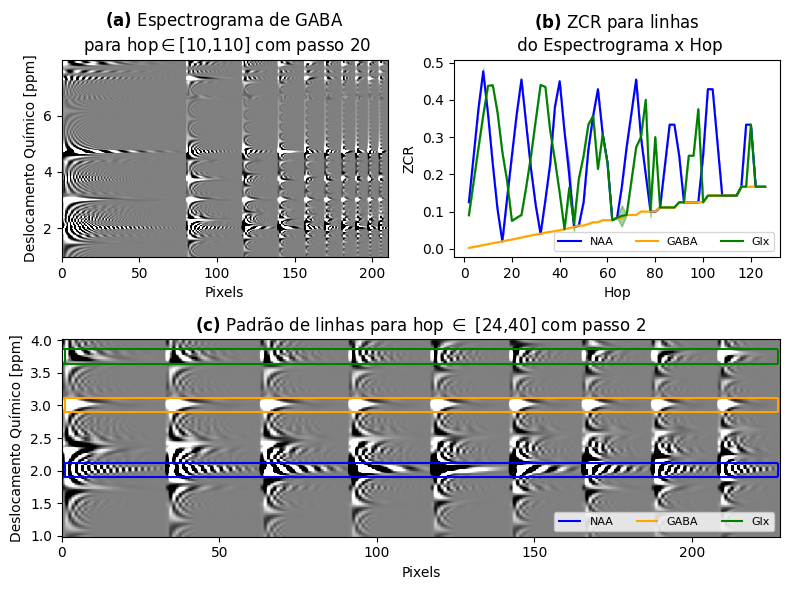

In [29]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,0])  
ax2 = fig.add_subplot(gs[0,1]) 
ax3 = fig.add_subplot(gs[1,:]) 

ax1.imshow(np.real(spgram_hop_concat_gt[idx_freq_1ppm[0]:idx_freq_8ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_gt.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_8ppm[0]]))
ax2.plot(hop_,gt_metrics['zcr_']['NAA']['mean'],color='b',label='NAA')
ax2.fill_between(hop_, np.array(gt_metrics['zcr_']['NAA']['mean']) - np.array(gt_metrics['zcr_']['NAA']['std']), 
                        np.array(gt_metrics['zcr_']['NAA']['mean']) + np.array(gt_metrics['zcr_']['NAA']['std']), alpha=0.35, color = 'b')
ax2.plot(hop_,gt_metrics['zcr_']['GABA']['mean'],color='orange',label='GABA')
ax2.fill_between(hop_, np.array(gt_metrics['zcr_']['GABA']['mean']) - np.array(gt_metrics['zcr_']['GABA']['std']), 
                        np.array(gt_metrics['zcr_']['GABA']['mean']) + np.array(gt_metrics['zcr_']['GABA']['std']), alpha=0.35, color = 'orange')
ax2.plot(hop_,gt_metrics['zcr_']['Glx']['mean'],color='g',label='Glx')
ax2.fill_between(hop_, np.array(gt_metrics['zcr_']['Glx']['mean']) - np.array(gt_metrics['zcr_']['Glx']['std']), 
                        np.array(gt_metrics['zcr_']['Glx']['mean']) + np.array(gt_metrics['zcr_']['Glx']['std']), alpha=0.35, color = 'g')
ax3.imshow(np.real(spgram_hop_concat_for_zcr_2[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_2.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))

ax1.set_title('$\mathbf{(a)}$ Espectrograma de GABA \n para hop$\in $[10,110] com passo 20',fontsize=12)
ax1.set_ylabel('Deslocamento Químico [ppm]',fontsize=10)
ax1.set_xlabel('Pixels',fontsize=10)
ax2.set_title('$\mathbf{(b)}$ ZCR para linhas \n do Espectrograma x Hop',fontsize=12)
ax2.set_ylabel('ZCR',fontsize=10)
ax2.set_xlabel('Hop',fontsize=10)
ax2.legend(loc='lower right', ncols=3,fontsize=8)
ax3.set_title('$\mathbf{(c)}$ Padrão de linhas para hop $\in$ [24,40] com passo 2',fontsize=12)
ax3.set_ylabel('Deslocamento Químico [ppm]',fontsize=10)
ax3.set_xlabel('Pixels',fontsize=10)
ax3.hlines(1.90,0.005,227.5,color='b',label='NAA')
ax3.hlines(2.11,0.005,227.5,color='b')
ax3.vlines(1,1.90,2.11,color='b')
ax3.vlines(227.5,1.90,2.11,color='b')
ax3.hlines(2.90,0.005,227.5,color='orange',label='GABA')
ax3.hlines(3.11,0.005,227.5,color='orange')
ax3.vlines(1,2.90,3.11,color='orange')
ax3.vlines(227.5,2.90,3.11,color='orange')
ax3.hlines(3.86,0.005,227.5,color='g',label='Glx')
ax3.hlines(3.64,0.005,227.5,color='g')
ax3.vlines(1,3.64,3.86,color='g')
ax3.vlines(227.5,3.64,3.86,color='g')
ax3.legend(loc='lower right',ncols=3,fontsize=8)

plt.tight_layout()
if test_not_save == False:
    plt.savefig('results_hop.png')

## 3.0 Resultados Extras

#### Nesta seção, estuda-se uma abordagem para avaliar as características estatísticas da influência do hop no espectrograma. Os resultados são elucidados aqui descrevendo padrões observados, no entanto, julgou-se difícil relacionar efeitos visuais com os efeitos medidos pelas métricas estatísticas indicadas, o que desmotivou a realização de análises desse tipo para outros parâmetros da STFT, pois notou-se pouco valor nas observações feitas em termos de caracterização do espectrograma.

### 3.1 Proposta de segmentação:

Para melhor compreender a distribuição dos valores da imagem, utilizaremos um método de segmentação por threshold, para a identificação do threshold, primeiro estuda-se os valores absolutos máximos de diferentes regiões da imagem.

Desse estudo, nota-se que podem existir alguns agrupamentos:

Para sinais gt: 
- Região 1: A região de resíduo tem valores máximos da ordem de 1e-3. Nota-se que a intensidade dos resíduos varia com o hop, com dois máximos distantes em média de 5 unidades de hop. A amplitude da variação do valor máximo fica mais intensa para maiores valores de hop.
- Região 2: Os valores máximos da região entre -4 e 1 ppm são muito próximos entre si, e próximos da região entre 6 e 7 ppm e entre 8.5 a 10 ppm. Tais regiões contém os picos de menor intensidade. Para tais regiões encontra-se um valor máximo próximo 0.02 para todo valor de hop. Nota-se ainda, que a partir de hop igual a 60, a intensidade dos valores de tais regiões diminui. Relembra-se que são nessas regiões de picos poucos intensos que o hop atua mudando a frequência dos picos.
- Região 3: A região entre 1 e 1,5 ppm e entre 5 e 6 ppm também apresenta valores máximos próximos, tais regiões são picos anexos a picos de alta intensidade, e, em média, o valor máximo de tais regiões cai com o aumento do hop. Os valores máximos de tais regiões encontram-se entre 0,02 e 0,06.
- Região 4: A região entre 7 e 8,5 ppm, entre 2,5 e 4 ppm (região do pico de GABA e Glx) também podem ser agrupadas juntas considerando a proximidade dos valores máximos. A variação do valor máximo da região do GABA com o hop é menor do que para as outras duas regiões consideradas, as quais, aparentam ter um valor máximo que oscila em torno de um valor constante (aproximadamente 0,12 para a região entre 7 e 8,5 ppm e em torno de 0,15 para a região do Glx). Os valores máximos de tais regiões estão entre 0,1 e 0,2.
- Região 5: Entre 4 e 5 ppm há um pico de alta intensidade cujo valor máximo parece oscilar em torno de 0,6 e estar sempre acima de 0,4.
- Região 6: Entre 1,5 e 2,5 ppm (região do pico de NAA), notam-se os valores máximos mais intensos da imagem. Apesar do valor máximo variar bastante com o hop, ele sestá sempre acima de 0,8.

Desse modo, para sinais gt, define-se os seguintes thresholds para segmentar a imagem:
- |x| < 0,001 (região de resíduo)
- 0,001 < |x| < 0,02 (região dos picos menos intensos)
- 0,02 < |x| < 0,08 (região em torno dos picos)
- 0,08 < |x| < 0,2 (região de alguns picos relevantes)
- 0,2 < |x| < 0,6 (região do pico entre 4 e 5 ppm)
- |x| > 0,6 (região do pico de NAA)


Para sinais ns, a existência do ruído torna os valores da região de resíduo mais intensos, e os picos menso intensos são substituídos por faixas de ruído, desse modo não é possível achar um simples threshold que separe tais regiões. Define-se a seguinte segmentação que tenta se aproximar das regiões segmentadas para os sinais gt:
- |x| < 0,02 (região de resíduo e faixas de ruído)
- 0,02 < |x| < 0,04 (região de contorno dos picos)
- 0,04 < |x| < 0,08 (região mais próxima dos picos)
- 0,08 < |x| < 0,2 (região de alguns picos relevantes)
- 0,2 < |x| < 0,6 (região do pico entre 4 e 5 ppm)
- |x| > 0,6 (região do pico de NAA)

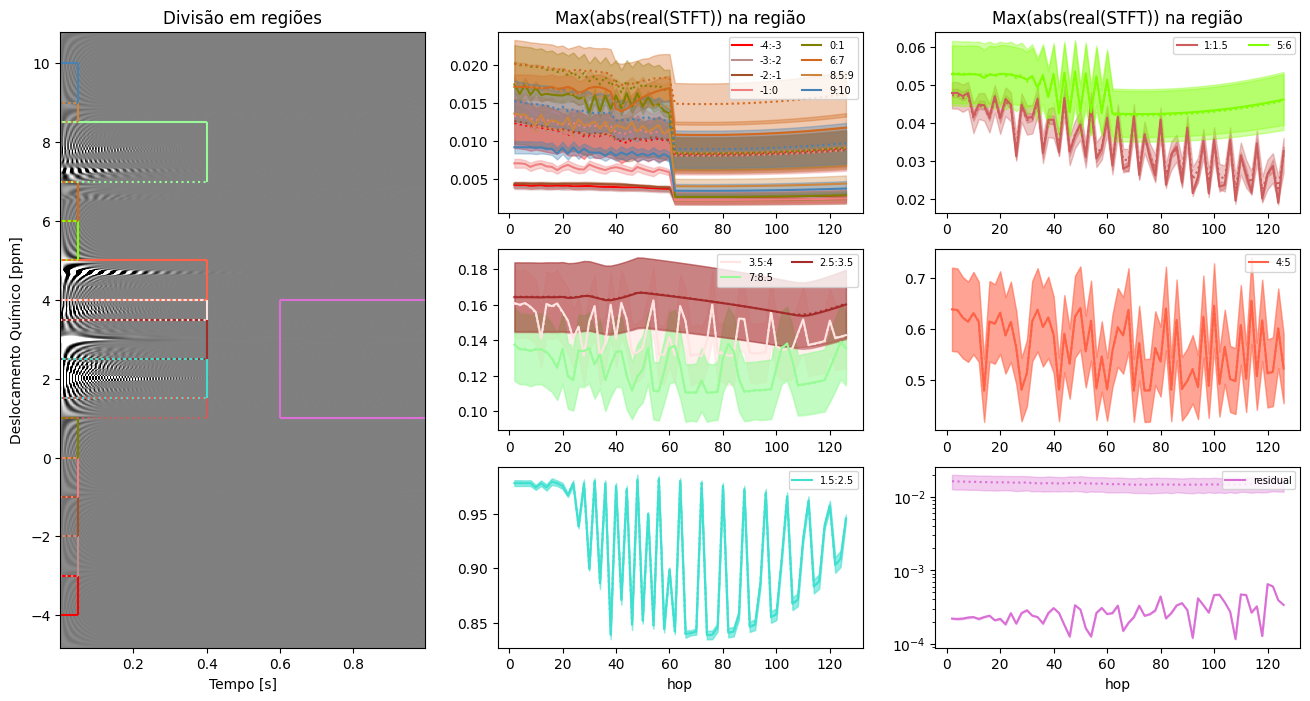

In [30]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])
axdiv = [fig.add_subplot(gs[0:, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
         fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
         fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2])]

hop_id = 3
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]
colors = ['red','rosybrown','sienna','lightcoral','olive','indianred','turquoise','brown','mistyrose','tomato','chartreuse','chocolate','palegreen','peru','steelblue']
times = [0.05,0.05,0.05,0.05,0.05,0.4,0.4,0.4,0.4,0.4,0.05,0.05,0.4,0.05,0.05]
dot = ['solid','dotted']
axdiv[0].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][-1],spgram_hop_gt['hop_'+str(hop_[hop_id])][2][-1],spgram_hop_gt['hop_'+str(hop_[hop_id])][2][0]))
for i in range(len(colors)):
    axdiv[0].vlines(times[i],sections[i],sections[i+1],color=colors[i])
    if i == 0:
        axdiv[0].hlines(sections[i],0.001,times[i],color=colors[i])
    else:
        axdiv[0].hlines(sections[i],0.001,times[i],color=colors[i],linestyle='dotted')
    if i == len(colors)-1:
        axdiv[0].hlines(sections[i+1],0.001,times[i],color=colors[i])
    else:
        axdiv[0].hlines(sections[i+1],0.001,times[i],color=colors[i],linestyle='solid')

axdiv[0].vlines(0.6,1,4,color='orchid')
axdiv[0].hlines(1,0.6,0.995,color='orchid')
axdiv[0].hlines(4,0.6,0.995,color='orchid')

axdiv[0].set_xlabel('Tempo [s]')
axdiv[0].set_ylabel('Deslocamento Químico [ppm]')
axdiv[0].set_title('Divisão em regiões')

plot_div = [[0,1,2,3,4,11,13,14],[5,10],[8,12,7],[9],[6]]
for i in range(len(plot_div)):
    for j in range(len(plot_div[i])):
            aux = gt_metrics['max_sec'][str(sections[plot_div[i][j]])+':'+str(sections[plot_div[i][j]+1])]['mean']
            aux_std = gt_metrics['max_sec'][str(sections[plot_div[i][j]])+':'+str(sections[plot_div[i][j]+1])]['std']
            axdiv[i+1].plot(hop_,aux,label =str(sections[plot_div[i][j]])+':'+str(sections[plot_div[i][j]+1]),color=colors[plot_div[i][j]])
            axdiv[i+1].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                            np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[plot_div[i][j]])
            aux = ns_metrics['max_sec'][str(sections[plot_div[i][j]])+':'+str(sections[plot_div[i][j]+1])]['mean']
            aux_std = ns_metrics['max_sec'][str(sections[plot_div[i][j]])+':'+str(sections[plot_div[i][j]+1])]['std']
            axdiv[i+1].plot(hop_,aux,color=colors[plot_div[i][j]],linestyle='dotted')
            axdiv[i+1].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                            np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[plot_div[i][j]])
    axdiv[i+1].legend(loc='upper right',ncols=2,fontsize=7)

aux = gt_metrics['max_sec']['residual']['mean']
aux_std = gt_metrics['max_sec']['residual']['std']
axdiv[-1].plot(hop_,aux,label ='residual',color='orchid')
axdiv[-1].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                np.array(aux) + np.array(aux_std), alpha=0.35, color='orchid')
aux = ns_metrics['max_sec']['residual']['mean']
aux_std = ns_metrics['max_sec']['residual']['std']
axdiv[-1].plot(hop_,aux,color='orchid',linestyle='dotted')
axdiv[-1].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                np.array(aux) + np.array(aux_std), alpha=0.35, color='orchid')
axdiv[-1].legend(loc='upper right',ncols=2,fontsize=7)
axdiv[-1].set_yscale('log')

axdiv[1].set_title('Max(abs(real(STFT)) na região')
axdiv[2].set_title('Max(abs(real(STFT)) na região')
axdiv[-1].set_xlabel('hop')
axdiv[-2].set_xlabel('hop')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_regioes_divisao.png')

### 3.2 Visualização da segmentação proposta:

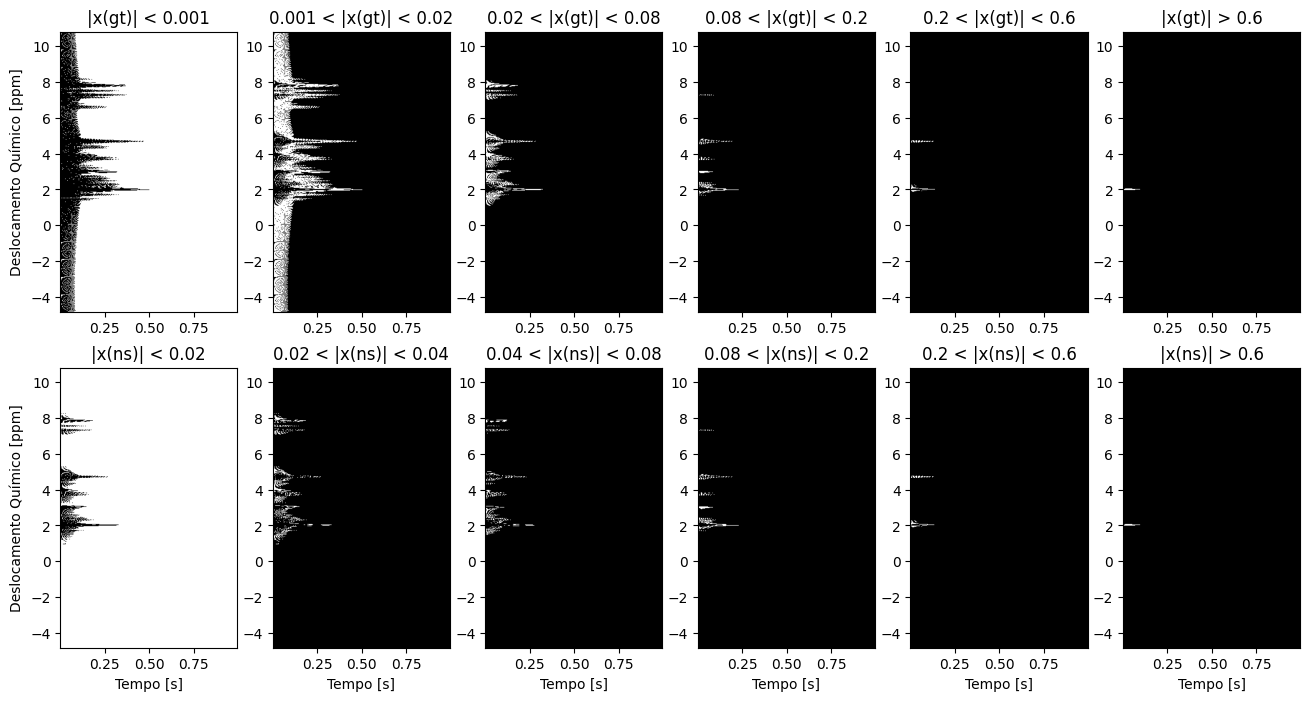

In [22]:
fig,ax = plt.subplots(2,6,figsize=(16,8))
hop_id = 3
row = 0

seg_res = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.001).astype('int')
seg_res2 = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.001).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.02).astype('int')
seg_res3 = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.08).astype('int')
seg_res4 = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.2).astype('int')
seg_res5 = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.6).astype('int')
seg_res6 = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[hop_id])][0][0,:,:])) < 1).astype('int')
    

ax.flat[0].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_gt['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_gt['hop_'+str(hop_[hop_id])][2])[-1]))

seg_res = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.02).astype('int')
seg_res2 = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.04).astype('int')
seg_res3 = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.08).astype('int')
seg_res4 = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.2).astype('int')
seg_res5 = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.6).astype('int')
seg_res6 = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[hop_id])][0][0,:,:])) < 1).astype('int')
    

ax.flat[6+0].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_ns['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_ns['hop_'+str(hop_[hop_id])][2])[-1]))

ax.flat[0].set_title('|x(gt)| < 0.001')
ax.flat[1].set_title('0.001 < |x(gt)| < 0.02')
ax.flat[2].set_title('0.02 < |x(gt)| < 0.08')
ax.flat[3].set_title('0.08 < |x(gt)| < 0.2')
ax.flat[4].set_title('0.2 < |x(gt)| < 0.6')
ax.flat[5].set_title('|x(gt)| > 0.6')
ax.flat[6+0].set_title('|x(ns)| < 0.02')
ax.flat[6+1].set_title('0.02 < |x(ns)| < 0.04')
ax.flat[6+2].set_title('0.04 < |x(ns)| < 0.08')
ax.flat[6+3].set_title('0.08 < |x(ns)| < 0.2')
ax.flat[6+4].set_title('0.2 < |x(ns)| < 0.6')
ax.flat[6+5].set_title('|x(ns)| > 0.6')
ax.flat[0].set_ylabel('Deslocamento Químico [ppm]')
ax.flat[6].set_ylabel('Deslocamento Químico [ppm]')
for i in range(6):
    ax.flat[6+i].set_xlabel('Tempo [s]')

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_segmented_regions.png')

### 3.3 Variação da quantidade de pixels em cada região segmentada:

Dada a segmentação proposta, busca-se primeiro entender como varia a porcentagem de pixels em cada região com o aumento do hop. Primeiramente, em termos absolutos, com a diminuição da quantidade de das colunas, nota-se uma redução na quantidade de pixels de todas as regiões. Em números relativos, nota-se que tanto para sinais gt quanto ns, a região correspondente ao resíduo (região 1) é a única cuja porcentagem decresce com o aumento do hop, as demais tendem a aumentar. Desse modo, entende-se que a quantidade de pixels da região 1 diminui mais rápido do que a quantidade total de pixels, enquanto para as demais regiões, a quantidade de pixels da região diminui mais devagar do que a redução na quantidade total de pixels. 

Para sinais do tipo gt, em que o nível dos resíduos é assumido sendo sempre inferior a 0,001, essa diminuição da concentração de resíduos e aumento da concentração de partes mais relevantes da imagem, nos permite levantar a seguinte hipótese: a diminuição da quantidade de colunas, i.e., a perda de informação da imagem com o aumento do hop, atinge mais a região de resíduo (os valores associados ao resíduo), do que a região que traz informações mais pertinentes a respeito do sinal FID GABA-editado. Em outras palavras, a STFT dos sinais em questão, permite preservar as informações mais relevantes em detrimento das informações residuais quando limita-se o tamanho/quantidade total de informação da imagem.

Interpretação análoga pode ser feita para os sinais do tipo ns. 

Nota-se que pelo estudo realizado, não se consegue afirmar se tal preservação vem por uma preservação dos valores mais intensos da imagem ou por uma perda de área da imagem que coincide com a região dos resíduos. 

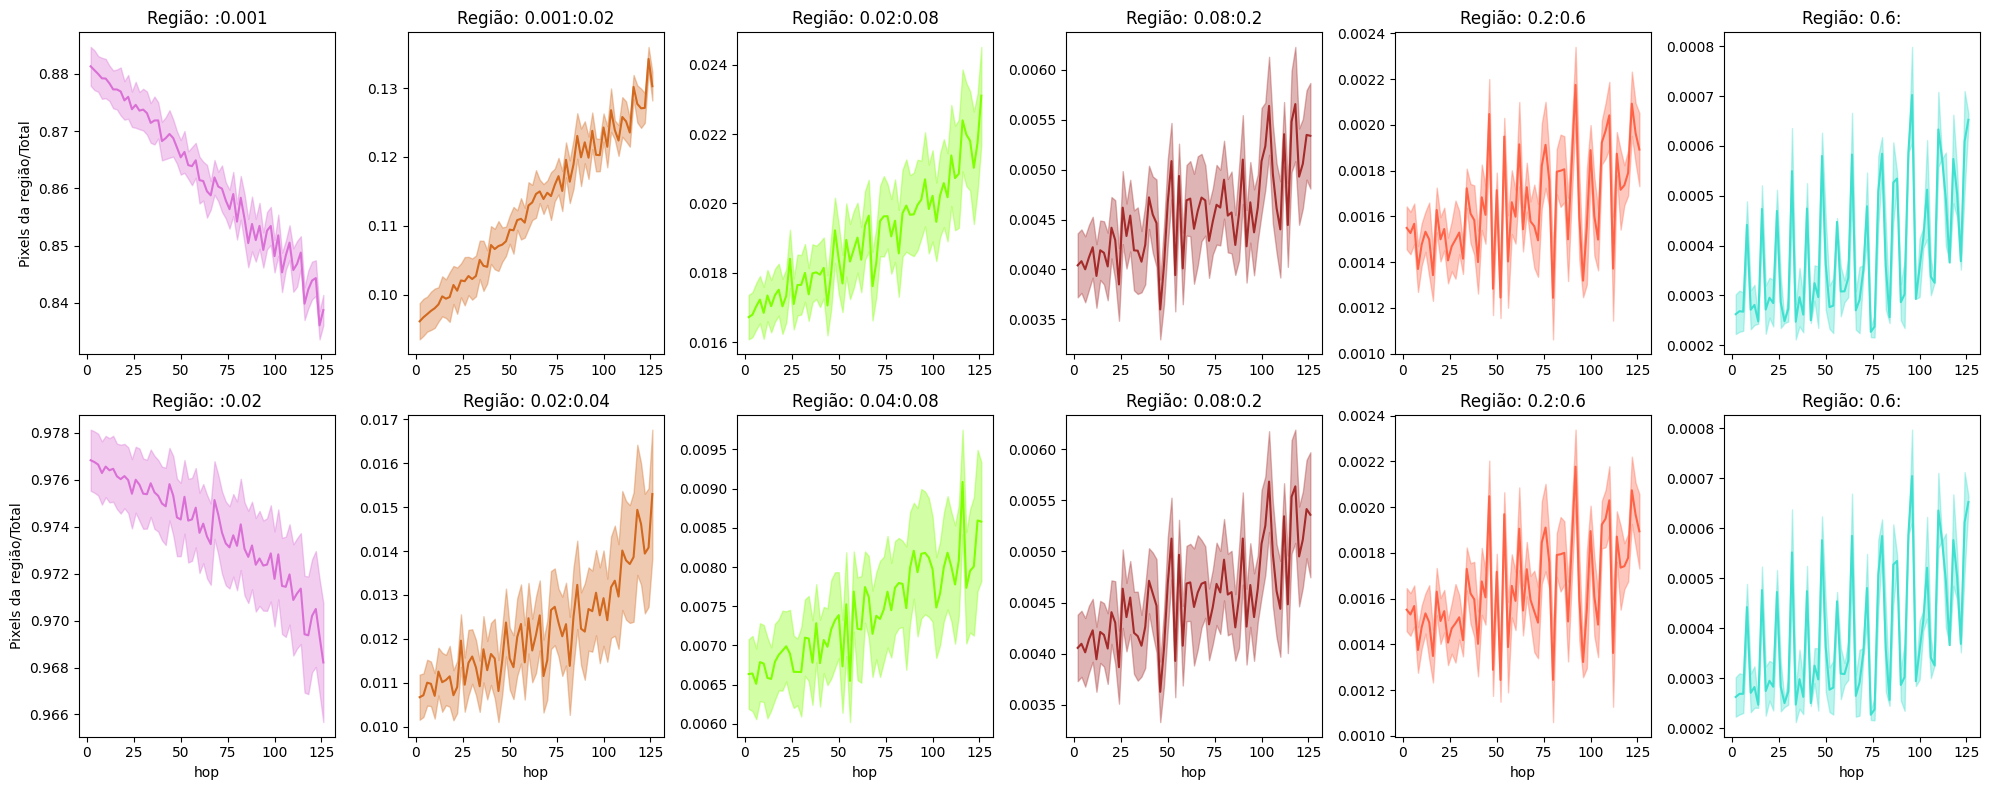

In [31]:
colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']
fig,ax = plt.subplots(2,6,figsize=(20,8))
for i in range(len(list(gt_metrics['qntty_percent_regions'].keys()))):
    aux = np.array(gt_metrics['qntty_percent_regions'][list(gt_metrics['qntty_percent_regions'].keys())[i]]['mean'])
    aux_std = np.array(gt_metrics['qntty_percent_regions'][list(gt_metrics['qntty_percent_regions'].keys())[i]]['std'])
    ax[0,i].plot(hop_,aux,color=colors[i])
    ax[0,i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    ax[0,i].set_title('Região: '+list(gt_metrics['qntty_percent_regions'].keys())[i])
    aux = np.array(ns_metrics['qntty_percent_regions'][list(ns_metrics['qntty_percent_regions'].keys())[i]]['mean'])
    aux_std = np.array(ns_metrics['qntty_percent_regions'][list(ns_metrics['qntty_percent_regions'].keys())[i]]['std'])
    ax[1,i].plot(hop_,aux,color=colors[i])
    ax[1,i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    ax[1,i].set_title('Região: '+list(ns_metrics['qntty_absolute_regions'].keys())[i])
    ax[1,i].set_xlabel('hop')
ax[0,0].set_ylabel('Pixels da região/Total')
ax[1,0].set_ylabel('Pixels da região/Total')
plt.tight_layout()
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_percentage_regions.png')

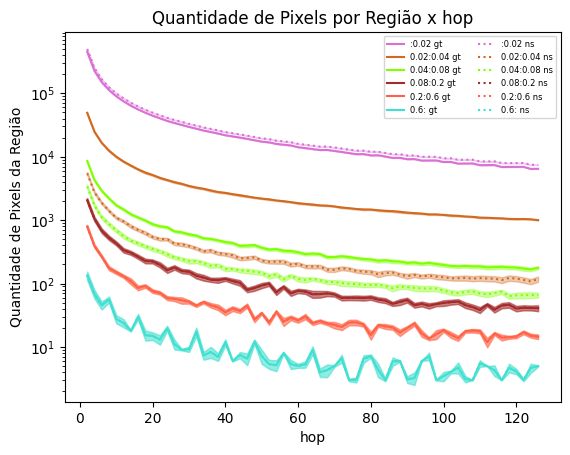

In [32]:
colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']

for i in range(len(list(gt_metrics['qntty_absolute_regions'].keys()))):
    aux_absolute = np.array(gt_metrics['qntty_absolute_regions'][list(gt_metrics['qntty_absolute_regions'].keys())[i]]['mean'])
    aux_absolute_std = np.array(gt_metrics['qntty_absolute_regions'][list(gt_metrics['qntty_absolute_regions'].keys())[i]]['std'])
    plt.plot(hop_,aux_absolute,color=colors[i],label=list(ns_metrics['qntty_absolute_regions'].keys())[i]+ ' gt')
    plt.fill_between(hop_, aux_absolute - aux_absolute_std, 
                       aux_absolute + aux_absolute_std, alpha=0.35, color = colors[i])
for i in range(len(list(gt_metrics['qntty_absolute_regions'].keys()))):
    aux_absolute = np.array(ns_metrics['qntty_absolute_regions'][list(ns_metrics['qntty_absolute_regions'].keys())[i]]['mean'])
    aux_absolute_std = np.array(ns_metrics['qntty_absolute_regions'][list(ns_metrics['qntty_absolute_regions'].keys())[i]]['std'])
    plt.plot(hop_,aux_absolute,color=colors[i],linestyle='dotted',label=list(ns_metrics['qntty_absolute_regions'].keys())[i]+ ' ns')
    plt.fill_between(hop_, aux_absolute - aux_absolute_std, 
                     aux_absolute + aux_absolute_std, alpha=0.35, color = colors[i])
aux = []
for i in range(len(hop_)):
    aux.append(spgram_hop_gt['hop_'+str(hop_[i])][0].shape[1]*spgram_hop_gt['hop_'+str(hop_[i])][0].shape[2])
plt.plot(hop_[1:],np.array(aux[1:])-np.array(aux[:-1]),color='black')

plt.yscale('log')
plt.legend(loc='upper right',ncols=2, fontsize=6)
plt.xlabel('hop')
plt.ylabel('Quantidade de Pixels da Região')
plt.title('Quantidade de Pixels por Região x hop')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_absolute_pixel_region.png')

### 3.4 Histogramas das regiões segmentadas:

Primeiramente, em termos globais, apenas a região de valores próximos de zero se destaca, pois a quantidade de valores menores que |0.25| é muito superior a quantidade de valores com maior intensidade, os quais necessitam de um amplo zoom para serem visualizados. Nota-se ainda que o hop interfere na simetria com relação ao zero, para hop = 2 e hop = 40 a faixa no lado positivo é mais alta que a do lado negativo, enquanto para os valores mais altos de hop, nota-se o contrário tanto para sinais gt quanto ns.

Para a região residual de sinais gt, nota-se um histograma também muito concentrado em valores muito próximos de zero (módulo inferior a 0.0005) e uma simetria também dependente do hop, de uma maneira não muito evidente. Já para os sinais ns, devido a característica gaussiana do ruído, nota-se um histograma mais bem distribuído entre os possíveis valores da região. Para hops mais altos parece haver maior concentração de valores extremos, em particular, para valores positivos. O histograma dessa região se assemelha ao da região entre 0,001:0,02 para sinais gt, onde, devido ao baixo valor do intervalo descartado, a descontinuidade da distribuição não aparece. Nota-se nessa região também um favorecimento a aparição de valores positivos para maiores valores de hop. Essa observação também pode ser extendida as regiões 0,02:0,08 (gt), 0,02:0,04 (ns), 0,04:0,08 (ns) e 0,08:0,2.

Para as demais regiões, a quantidade de pixels diminui consideravelmente, essa escassez de dados torna o histograma muito dependente de pequenas variações nas regiões, e assim é difícil observar uma tendência fixa. 

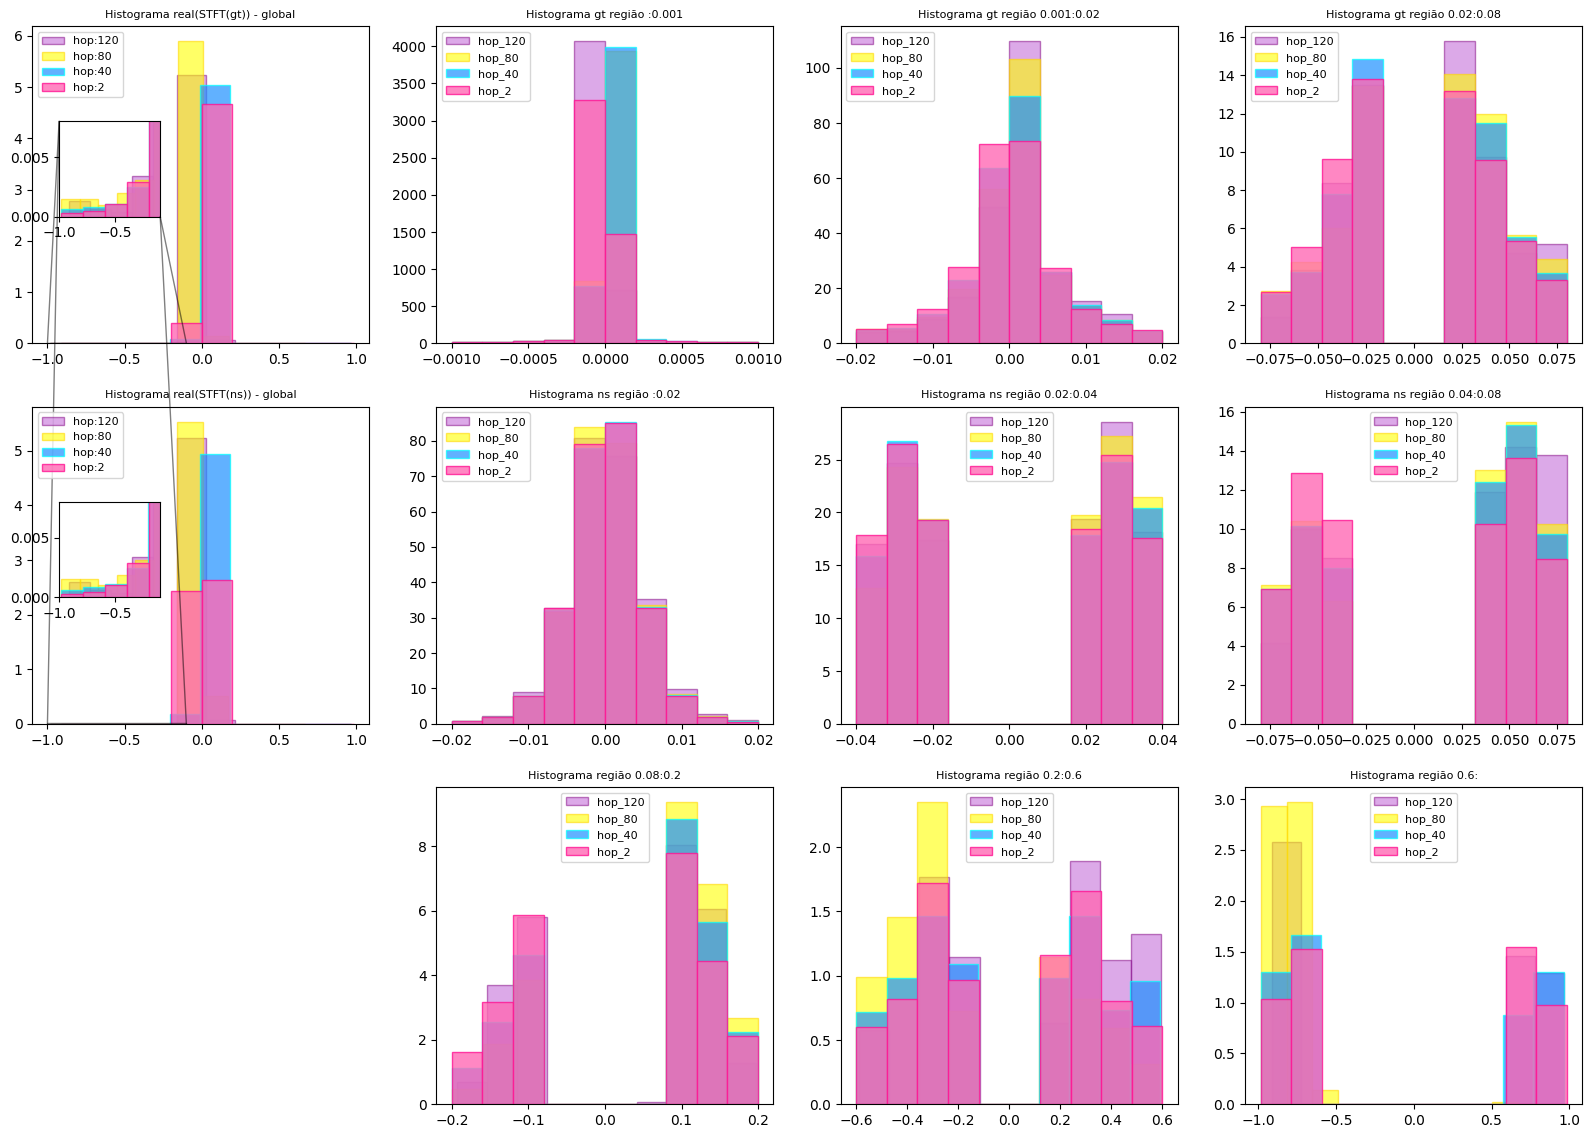

In [33]:
fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1])
axdiv = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3]),
         fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3]),
         fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[2, 3])]


axins = axdiv[0].inset_axes([0.08, 0.4, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.008))
axdiv[0].indicate_inset_zoom(axins, edgecolor="black")
axins2 = axdiv[4].inset_axes([0.08, 0.4, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.008))
axdiv[4].indicate_inset_zoom(axins, edgecolor="black")

plot_id = [0,19,39,59]
alphas = [0.8,0.7,0.6,0.5]
colors = ['hotpink','dodgerblue','yellow','mediumorchid']
color_edges = ['deeppink','cyan','gold','purple']
for i in reversed(range(len(plot_id))):
    axdiv[0].hist(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).flatten(),density=True,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],label='hop:'+str(hop_[plot_id[i]]))
    axins.hist(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).flatten(),density=True,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],label='hop:'+str(hop_[plot_id[i]]))
    axdiv[4].hist(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]).flatten(),density=True,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],label='hop:'+str(hop_[plot_id[i]]))
    axins2.hist(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]).flatten(),density=True,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],label='hop:'+str(hop_[plot_id[i]]))
    axdiv[0].legend(loc='upper left',fontsize=8)
    axdiv[4].legend(loc='upper left',fontsize=8)
    
    seg_ = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) < 0.001).astype('int')
    aux = np.real(seg_*spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    axdiv[1].hist(aux,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[1].legend(loc='upper left',fontsize=8)
    seg_ = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])) < 0.02).astype('int')
    aux = np.real(seg_*spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    axdiv[5].hist(aux,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[5].legend(loc='upper left',fontsize=8)

    seg_ = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) > 0.001).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) < 0.02).astype('int')
    aux = np.real(seg_*spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    aux_no_zeros = aux[aux != 0]
    axdiv[2].hist(aux_no_zeros,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[2].legend(loc='upper left',fontsize=8)
    seg_ = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])) < 0.04).astype('int')
    aux = np.real(seg_*spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    aux_no_zeros = aux[aux != 0]
    axdiv[6].hist(aux_no_zeros,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[6].legend(loc='upper center',fontsize=8)

    seg_ = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) < 0.08).astype('int')
    aux = np.real(seg_*spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    aux_no_zeros = aux[aux != 0]
    axdiv[3].hist(aux_no_zeros,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[3].legend(loc='upper left',fontsize=8)
    seg_ = (np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])) < 0.08).astype('int')
    aux = np.real(seg_*spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    aux_no_zeros = aux[aux != 0]
    axdiv[7].hist(aux_no_zeros,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[7].legend(loc='upper center',fontsize=8)

    seg_ = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) < 0.2).astype('int')
    aux = np.real(seg_*spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    aux_no_zeros = aux[aux != 0]
    axdiv[9].hist(aux_no_zeros,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[9].legend(loc='upper center',fontsize=8)

    seg_ = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) < 0.6).astype('int')
    aux = np.real(seg_*spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    aux_no_zeros = aux[aux != 0]
    axdiv[10].hist(aux_no_zeros,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[10].legend(loc='upper center',fontsize=8)

    seg_ = (np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])) > 0.6).astype('int')
    aux = np.real(seg_*spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]).ravel()
    aux_no_zeros = aux[aux != 0]
    axdiv[11].hist(aux_no_zeros,alpha=alphas[i],color=colors[i],edgecolor=color_edges[i],density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    axdiv[11].legend(loc='upper center',fontsize=8)

axdiv[0].set_title('Histograma real(STFT(gt)) - global',fontsize=8)
axdiv[4].set_title('Histograma real(STFT(ns)) - global',fontsize=8)
axdiv[1].set_title('Histograma gt região :0.001',fontsize=8)
axdiv[5].set_title('Histograma ns região :0.02',fontsize=8)
axdiv[2].set_title('Histograma gt região 0.001:0.02',fontsize=8)
axdiv[6].set_title('Histograma ns região 0.02:0.04',fontsize=8)
axdiv[3].set_title('Histograma gt região 0.02:0.08',fontsize=8)
axdiv[7].set_title('Histograma ns região 0.04:0.08',fontsize=8)
axdiv[9].set_title('Histograma região 0.08:0.2',fontsize=8)
axdiv[10].set_title('Histograma região 0.2:0.6',fontsize=8)
axdiv[11].set_title('Histograma região 0.6:',fontsize=8)
axdiv[8].axis('off')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_histograms.png')

### 3.5 Estatísticas levantadas para cada região segmentada:

#### 3.5.1 Mediana

Globalmente, para sinais do tipo gt, a mediana tende a ser zero para todo valor de hop. O mesmo ocorre para a região de resíduo, a qual é a maior região da imagem e é quem tem maior impacto sobre a mediana, como pode-se observar notando a mediana global e aquela da região de ruído para sinais ns, cujas curvas são idênticas e aumentam com o hop. A mediana mais positiva indica que o aumento do hop favorece os valores positivos da imagem, comportamento observado pelo histograma da região :0.02 de sinais ns. 

Para maior parte das regiões, a mediana tende a ser positiva, principalmente para maiores valores de hop. Para as regiões 0,2:0,6 e 0.6:, regiões de picos listrados, a mediana varia entre positiva e negativa conforme o hop, o qual, como observado anteriormente, modifica o padrão de listras da imagem. Assim, entende-se que como há poucos pixels nessas regiões, é o balanço entre faixas pretas e brancas que dita o valor mediano nessas regiões.


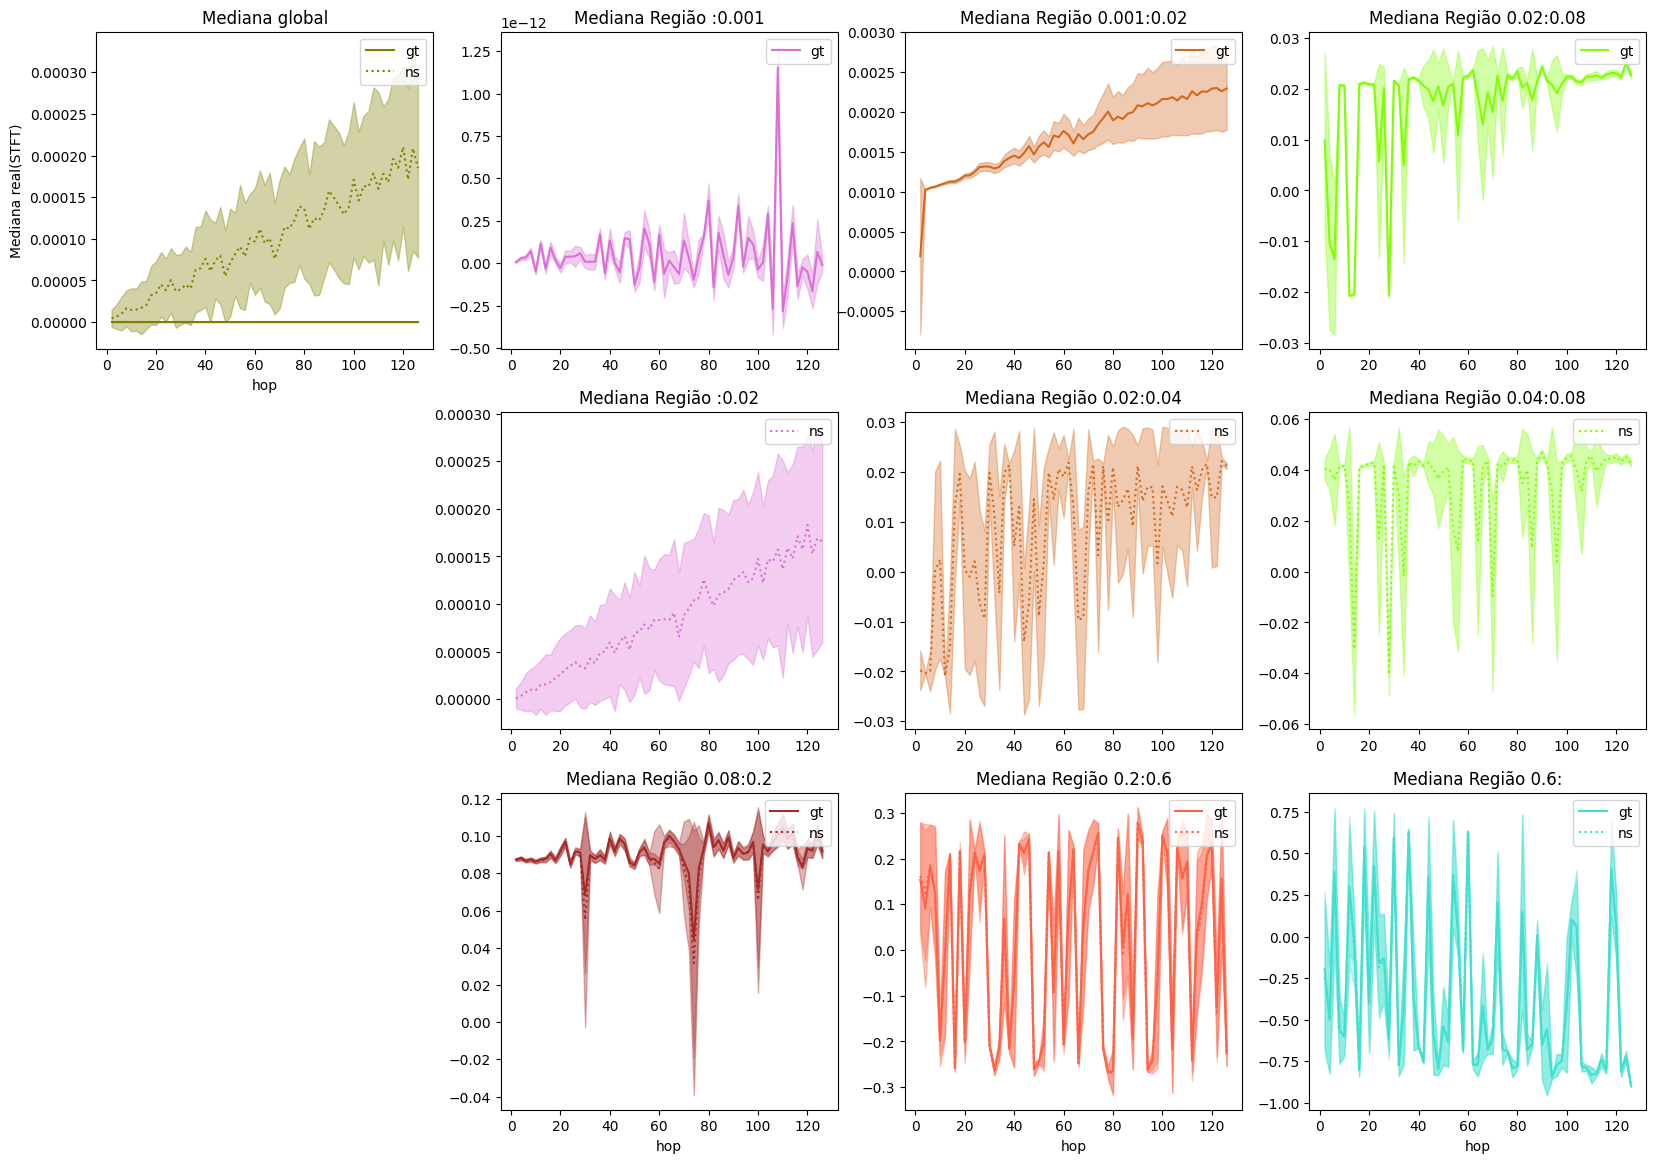

In [34]:
colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']
stat_name = 'median'

fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1])
axdiv = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3]),
         fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3]),
         fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[2, 3]),fig.add_subplot(gs[1, 0])]


aux = np.array(gt_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(gt_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='gt')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
aux = np.array(ns_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(ns_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='ns',linestyle='dotted')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
axdiv[0].set_title('Mediana global')
axdiv[0].legend(loc='upper right')
axdiv[0].set_xlabel('hop')
axdiv[0].set_ylabel('Mediana real(STFT)')

for i in range(3):
        aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[i+1].plot(hop_,aux,color=colors[i],label='gt')
        axdiv[i+1].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[i+1].set_title('Mediana Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[1+i].legend(loc='upper right')
        aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[4+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
        axdiv[4+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[4+i].set_title('Mediana Região '+list(ns_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[4+i].legend(loc='upper right')

for i in range(3,len(list(ns_metrics['stats_per_region'][stat_name].keys()))):
    aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[i+5].plot(hop_,aux,color=colors[i],label='gt')
    axdiv[i+5].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[5+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
    axdiv[5+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    axdiv[i+5].set_title('Mediana Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
    axdiv[5+i].set_xlabel('hop')
    axdiv[5+i].legend(loc='upper right')
    
axdiv[7].axis('off')
axdiv[-1].axis('off')
plt.tight_layout
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_mediana.png')

#### 3.5.2 Média

Diferentemente da mediana, a média, que é mais afetada pela presença de valores extremos, tende a oscilar em torno de zero, não assumindo um comportamento bem definido com o hop. Enquanto a mediana global tem uma alta correspondência com a mediana da região residual ou de ruído, a media global tem maior correlação com as regiões 0,2:0,6 e 0,6: (corr = 0,83; p = 2e-17 e corr =0,47; p = 8e-5, respectivamente), as quais são as regiões que apresentam os valores mais intensos e cujas médias também oscilam em torno de zero. Uma hipótese a respeito da região entre 0,08:0,2 não apresentar oscilações e ter sempre a média acima de zero é a presença do pico de GABA, o qual contém apenas valores positivos. 

As demais regiões apresentam média positiva e crescente com o hop, novamente reforçando a hipótese de que um maior hop favorece valores positivos da imagem. 

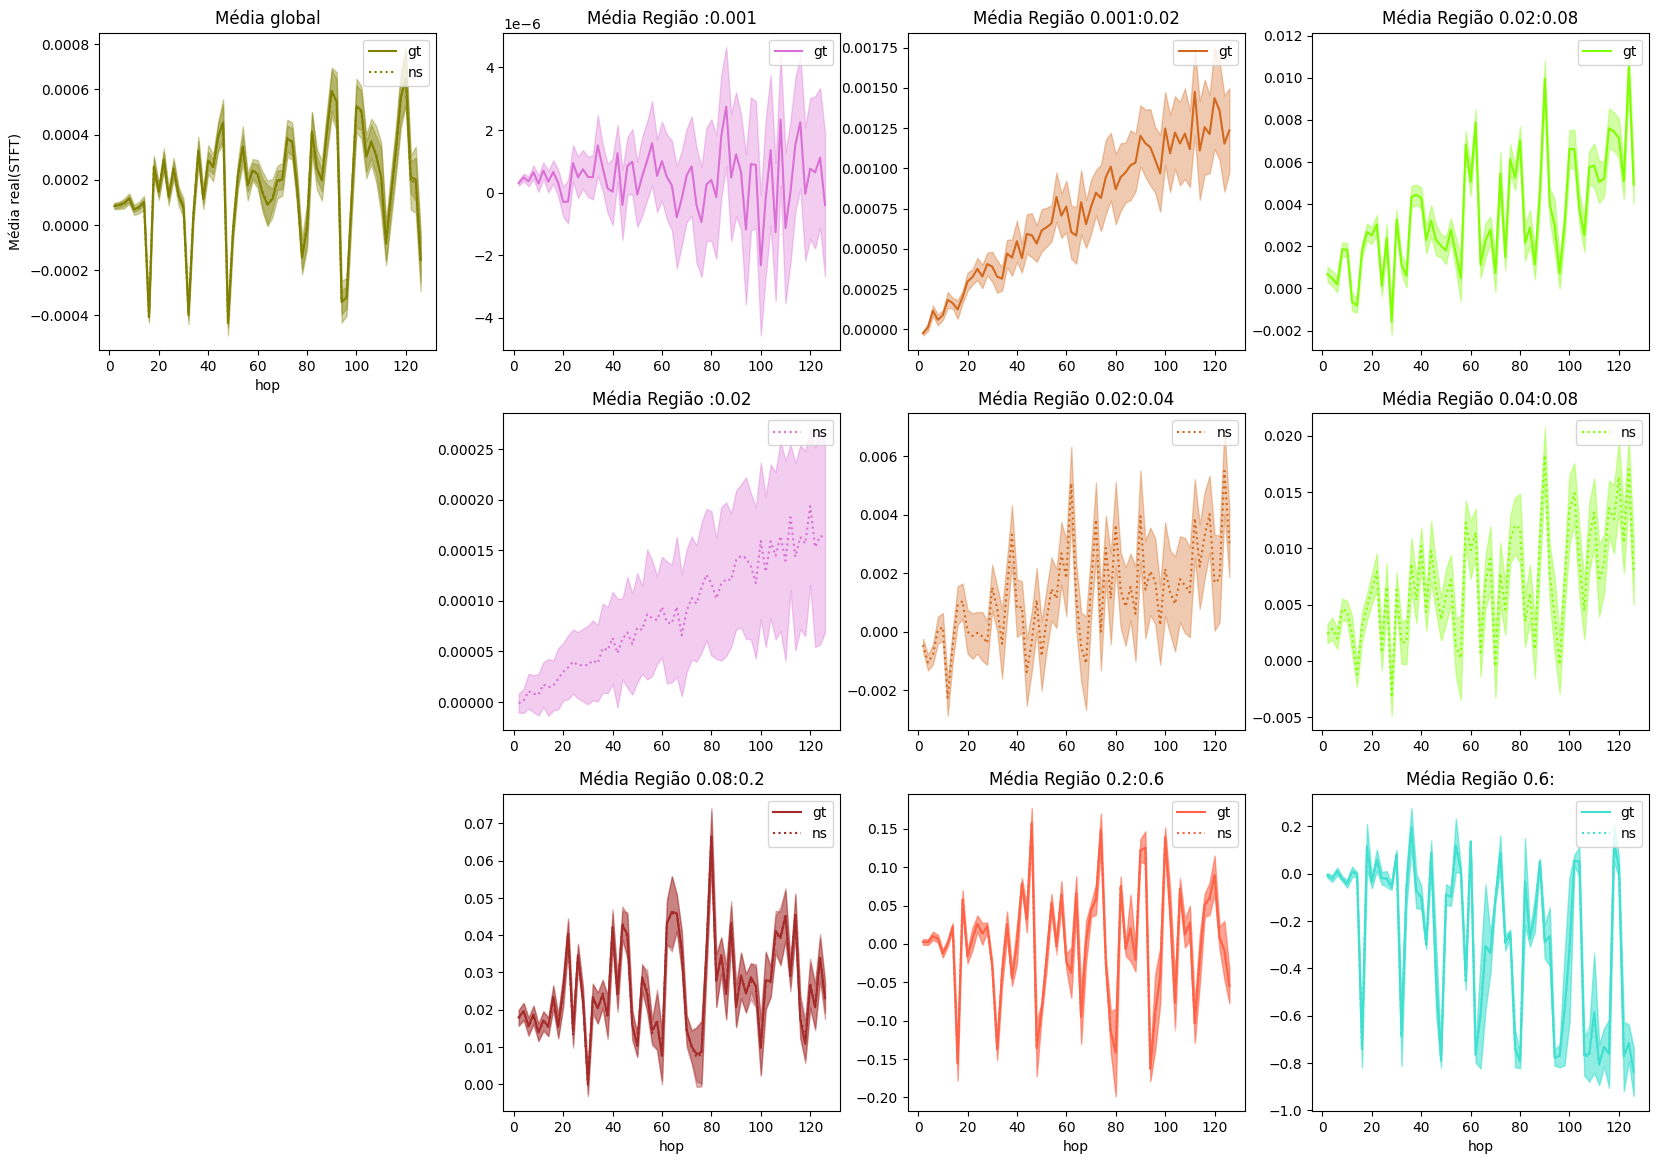

In [35]:
colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']
stat_name = 'mean'

fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1])
axdiv = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3]),
         fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3]),
         fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[2, 3]),fig.add_subplot(gs[1, 0])]


aux = np.array(gt_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(gt_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='gt')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
aux = np.array(ns_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(ns_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='ns',linestyle='dotted')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
axdiv[0].set_title('Média global')
axdiv[0].legend(loc='upper right')
axdiv[0].set_xlabel('hop')
axdiv[0].set_ylabel('Média real(STFT)')

for i in range(3):
        aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[i+1].plot(hop_,aux,color=colors[i],label='gt')
        axdiv[i+1].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[i+1].set_title('Média Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[1+i].legend(loc='upper right')
        aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[4+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
        axdiv[4+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[4+i].set_title('Média Região '+list(ns_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[4+i].legend(loc='upper right')

for i in range(3,len(list(ns_metrics['stats_per_region'][stat_name].keys()))):
    aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[i+5].plot(hop_,aux,color=colors[i],label='gt')
    axdiv[i+5].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[5+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
    axdiv[5+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    axdiv[i+5].set_title('Média Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
    axdiv[5+i].set_xlabel('hop')
    axdiv[5+i].legend(loc='upper right')
    
axdiv[7].axis('off')
axdiv[-1].axis('off')
plt.tight_layout
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_media.png')

Text(0.5, 1.0, 'Relação entre média global e média na região 0.2:0.6')

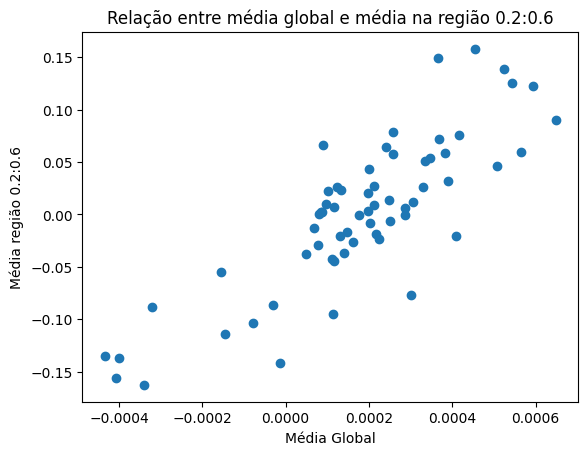

In [37]:
plt.scatter(gt_metrics['stats_global']['mean']['mean'],gt_metrics['stats_per_region']['mean']['0.2:0.6']['mean'])
plt.xlabel('Média Global')
plt.ylabel('Média região 0.2:0.6')
plt.title('Relação entre média global e média na região 0.2:0.6')

#### 3.5.3 Desvio-padrão

Globalmente, nota-se um aumento do desvio padrão com o aumento do hop, porém, diferentemente da média e mediana, não é claro explicar qual região influencia mais no desvio padrão, e não se nota nenhuma outra região, com exceção da região :0,02 para sinais ns, em que o desvio padrão aumenta com o hop. Como essa tendência global ocorre tanto para sinais ns quanto gt, a região de resíduo/ruído não é capaz de explicar o fenômeno global. 

De forma geral, entende-se que o hop afeta mais o desvio padrão das regiões :0,001 e 0,001:0,02 para sinais gt e regiões :0,02 e 0,02:0,04 para sinais ns. Um fator interessante é comparar o desvio padrão da região :0,06 com o ZCR do pico NAA, nota-se que ambos decrescem juntos (corr = 0,61; p = 1e-7), o que nos leva a supor que o padrão de listras influencia bastante o desvio padrão de cada região da imagem, e como o padrão de listras varia de forma não uniforme com o hop, entende-se o porquê na maioria das regiões a mudança do hop parece fazer o desvio padrão oscilar em torno de um valor médio.

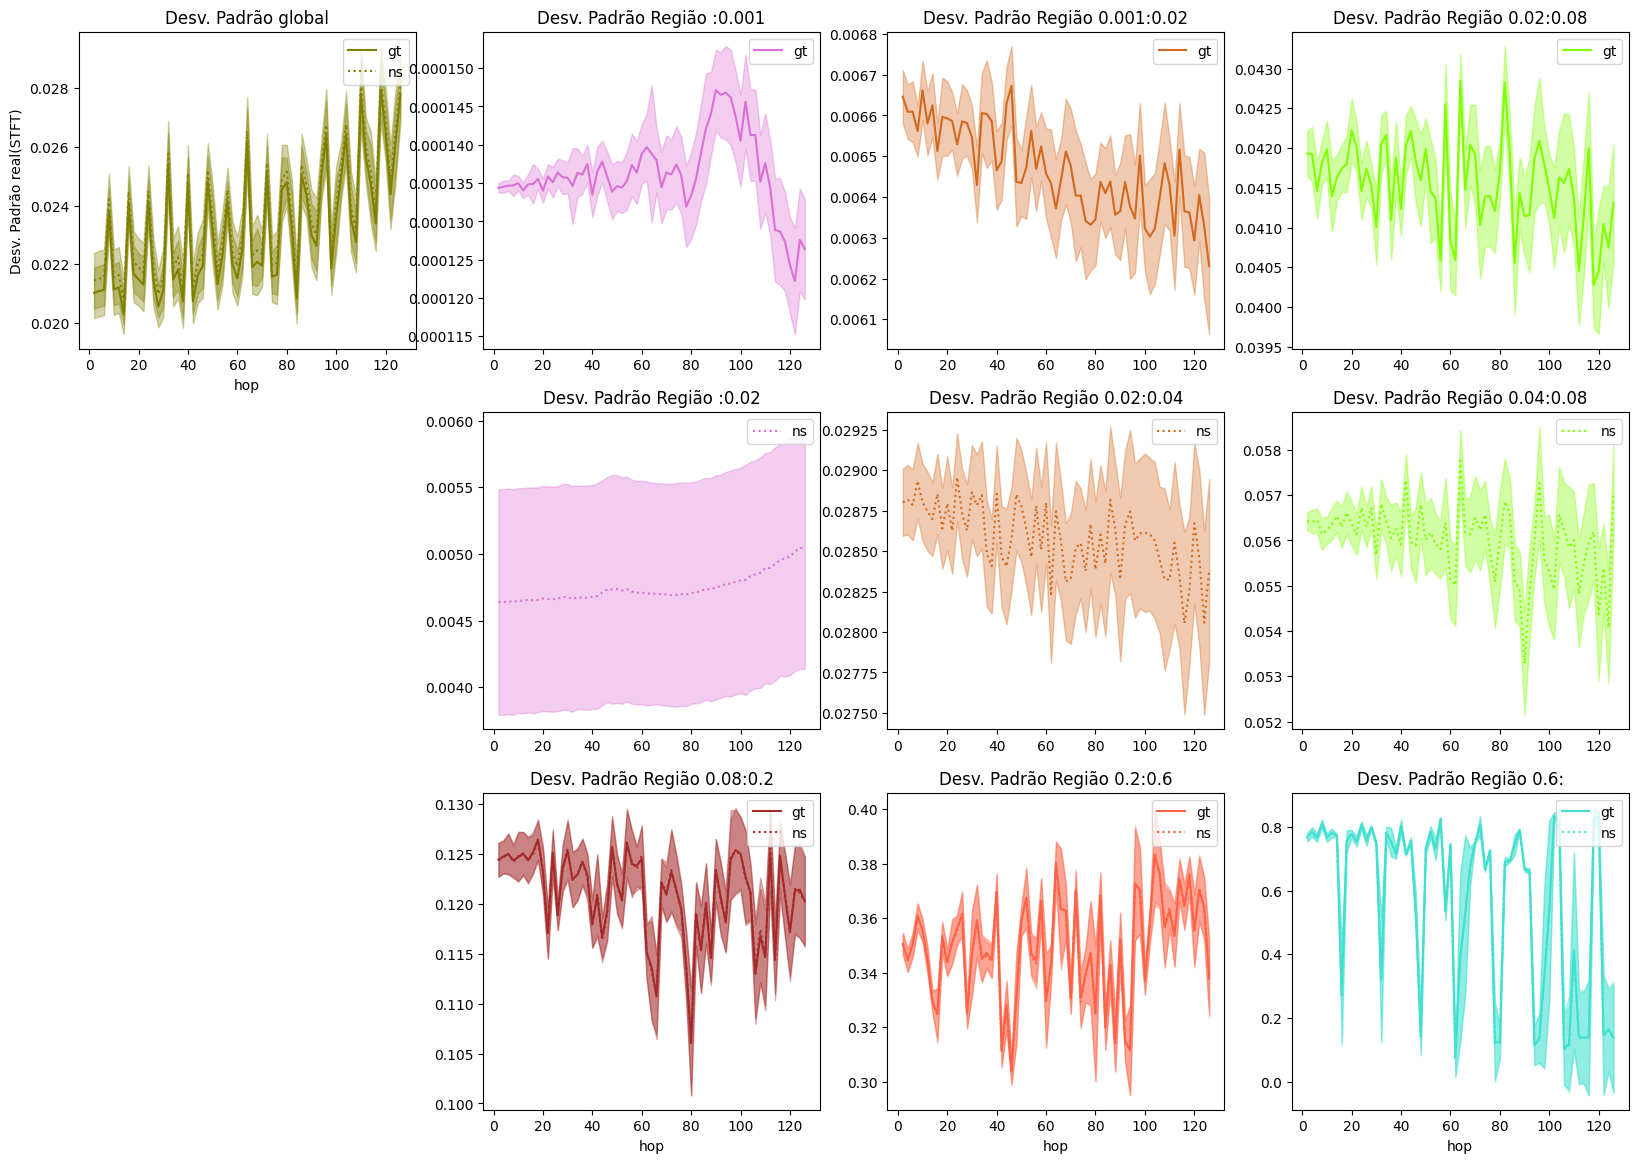

In [38]:
colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']
stat_name = 'std'

fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1])
axdiv = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3]),
         fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3]),
         fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[2, 3]),fig.add_subplot(gs[1, 0])]


aux = np.array(gt_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(gt_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='gt')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
aux = np.array(ns_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(ns_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='ns',linestyle='dotted')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
axdiv[0].set_title('Desv. Padrão global')
axdiv[0].legend(loc='upper right')
axdiv[0].set_xlabel('hop')
axdiv[0].set_ylabel('Desv. Padrão real(STFT)')

for i in range(3):
        aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[i+1].plot(hop_,aux,color=colors[i],label='gt')
        axdiv[i+1].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[i+1].set_title('Desv. Padrão Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[1+i].legend(loc='upper right')
        aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[4+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
        axdiv[4+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[4+i].set_title('Desv. Padrão Região '+list(ns_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[4+i].legend(loc='upper right')

for i in range(3,len(list(ns_metrics['stats_per_region'][stat_name].keys()))):
    aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[i+5].plot(hop_,aux,color=colors[i],label='gt')
    axdiv[i+5].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[5+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
    axdiv[5+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    axdiv[i+5].set_title('Desv. Padrão Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
    axdiv[5+i].set_xlabel('hop')
    axdiv[5+i].legend(loc='upper right')
    
axdiv[7].axis('off')
axdiv[-1].axis('off')
plt.tight_layout
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_std.png')

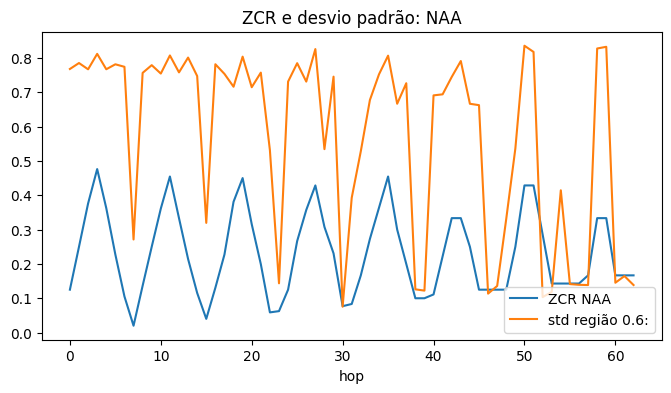

In [39]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(gt_metrics['zcr_']['NAA']['mean'], label='ZCR NAA')
ax.plot(gt_metrics['stats_per_region']['std']['0.6:']['mean'], label = 'std região 0.6:')
ax.set_xlabel('hop')
ax.set_title('ZCR e desvio padrão: NAA')
ax.legend(loc='lower right')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_zcr_std_corr.png')

### 3.5.4 Skewness

O skewness global tem uma alta correlação com o desvio padrão da região 0,6: (corr = 0.89; p = 9e-23), o que sugere que a variação do skewness com o hop está ligada a variação do padrão de listras, em especial nos picos mais intensos da imagem. Tal ideia faz sentido dado que tal padrão que torna uma dada região mais negativa ou mais positiva. 

Na maior parte das regiões, o skewness é negativo e fica mais negativo com o aumento do hop para as regiões 0,001:0,02 e 0,02:0,08 (gt) e 0,02:0,04 e 0,04:0,08 (ns). Para tais regiões a correlação entre o skewness e a média é inferior a -0,84 (gt) e -0,98 (ns) (p na ordem de 1e-20 (gt) e 1e-50 (ns)), isso tem sentido visto que constatou-se que o aumento do hop favorece a aparição de valores positivos nessas regiões, ou seja, tornam as regiões mais left-skewed, pois o centro de massa da distribuição de valores se desloca para a direita (região de valores positivos). 

Nas regiões 0,08:0,2 e 0,2:0,6 a correlação entre a média e o skewness é -0,97 (p = 1e-42) e -0,95 (p = 1e-34), respectivamente. Foi sugerido que o que impacta a média em tais regiões é o padrão de listras e a presença do pico de GABA na região 0,08:0,2. Pela análise do skewness global, parece justo indicar que o padrão de listras também é o que influencia o skewness nessas regiões.

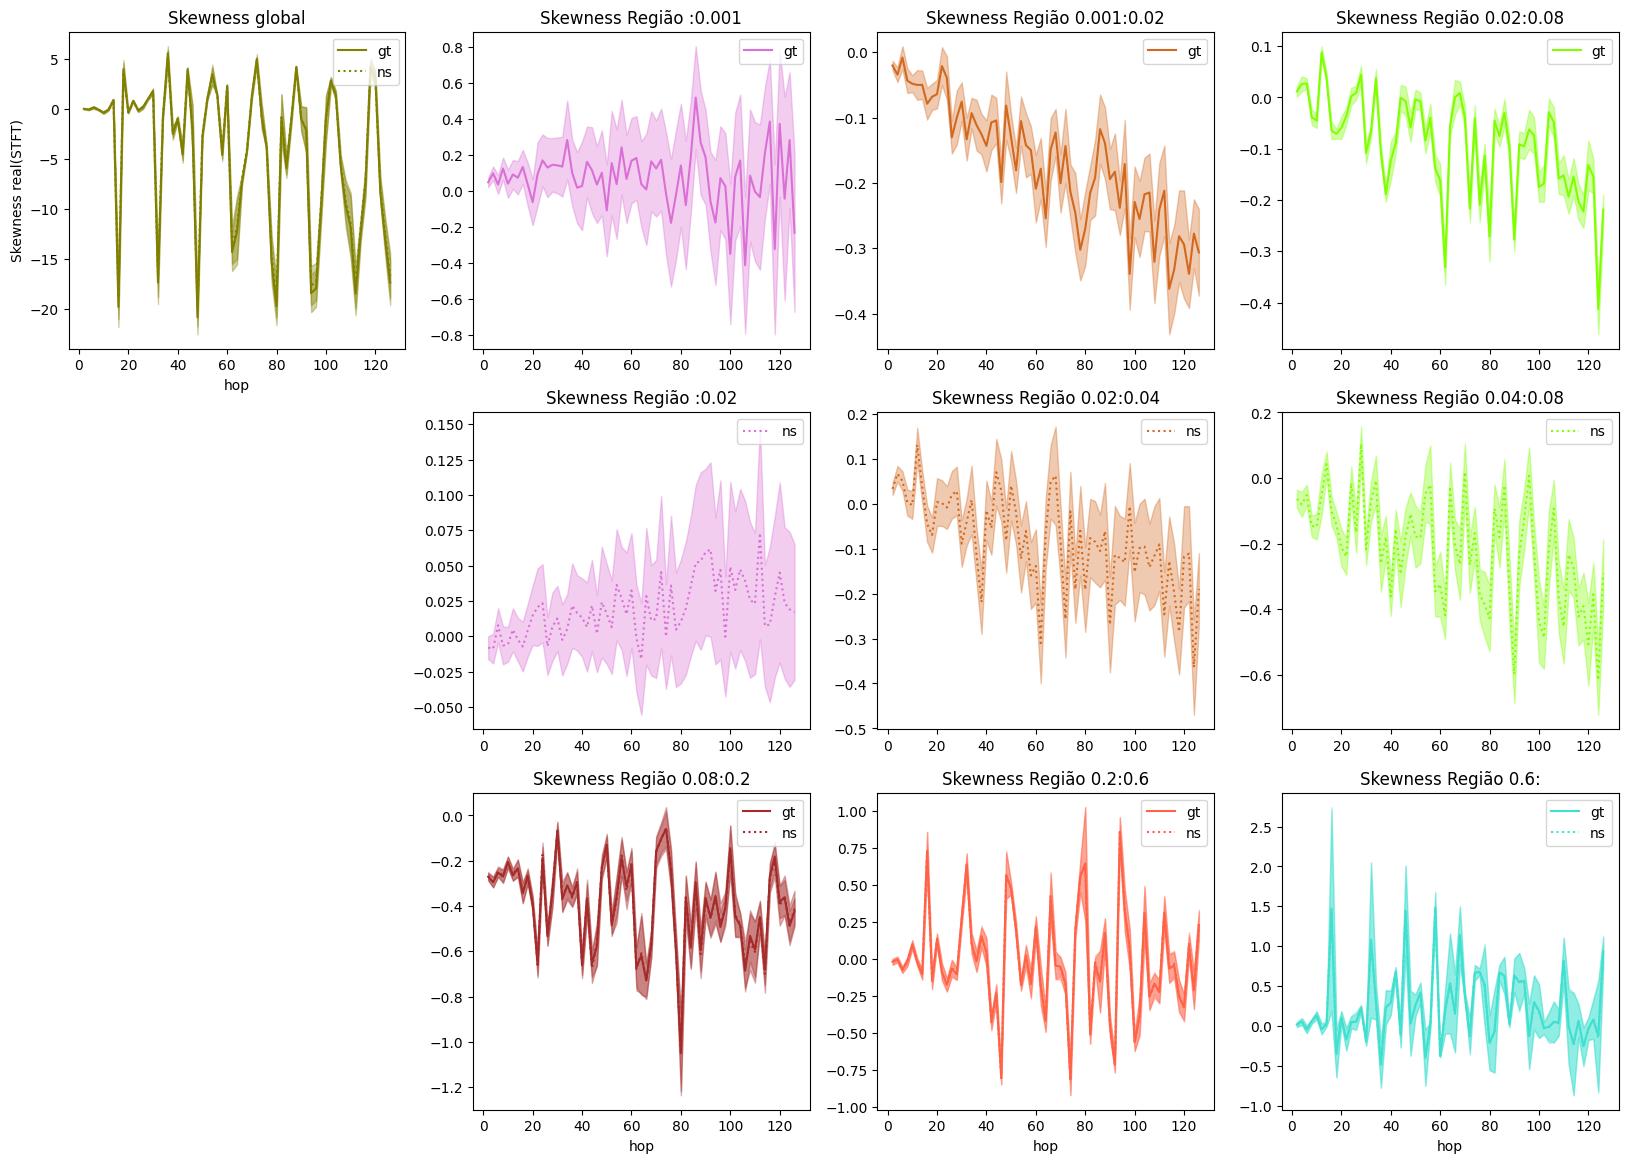

In [40]:
colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']
stat_name = 'skewness'

fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1])
axdiv = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3]),
         fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3]),
         fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[2, 3]),fig.add_subplot(gs[1, 0])]


aux = np.array(gt_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(gt_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='gt')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
aux = np.array(ns_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(ns_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='ns',linestyle='dotted')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
axdiv[0].set_title('Skewness global')
axdiv[0].legend(loc='upper right')
axdiv[0].set_xlabel('hop')
axdiv[0].set_ylabel('Skewness real(STFT)')

for i in range(3):
        aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[i+1].plot(hop_,aux,color=colors[i],label='gt')
        axdiv[i+1].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[i+1].set_title('Skewness Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[1+i].legend(loc='upper right')
        aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[4+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
        axdiv[4+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[4+i].set_title('Skewness Região '+list(ns_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[4+i].legend(loc='upper right')

for i in range(3,len(list(ns_metrics['stats_per_region'][stat_name].keys()))):
    aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[i+5].plot(hop_,aux,color=colors[i],label='gt')
    axdiv[i+5].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[5+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
    axdiv[5+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    axdiv[i+5].set_title('Skewness Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
    axdiv[5+i].set_xlabel('hop')
    axdiv[5+i].legend(loc='upper right')
    
axdiv[7].axis('off')
axdiv[-1].axis('off')
plt.tight_layout
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_skewness.png')

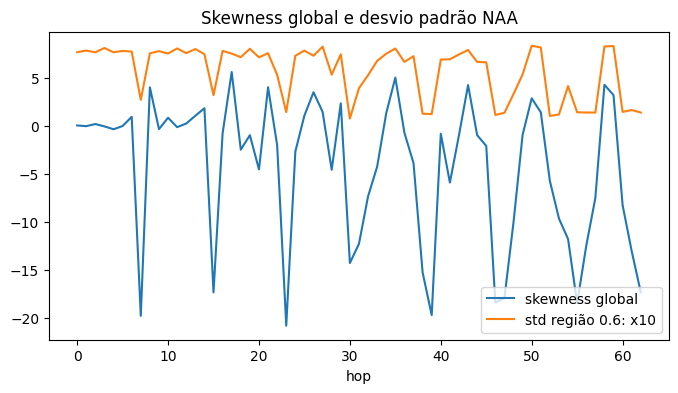

In [42]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(gt_metrics['stats_global']['skewness']['mean'], label='skewness global')
ax.plot(np.array(gt_metrics['stats_per_region']['std']['0.6:']['mean'])*10, label = 'std região 0.6: x10')
ax.set_xlabel('hop')
ax.set_title('Skewness global e desvio padrão NAA')
ax.legend(loc='lower right')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_skewness_std_corr.png')

#### 3.5.5 Kurtosis

Nota: kurtosis aqui na verdade se refere a excess kurtosis, a qual é kurtosis - 3.

Globalmente, a kurtosis é positiva e diminui com o hop. Comparando o histograma das nossas imagens com o histograma de uma curva normal com o mesmo desvio padrão (aproximadamente 0,020 e média 0), nota-se que, apesar do nosso histograma ser muito concentrado no centro, ele ainda apresenta valores mais intensos até próximos de -1 e 1, o que não é respresentativo em uma distribuição normal, visto que valores próximos de 1 são 50 vezes maiores que o desvio padrão. Assim, são os picos da imagem e outros elementos não residuais, que tornam a kurtosis dos nossos espectrogramas muito positiva. Além disso, nota-se uma diminuição da kurtosis com o aumento do hop. Considerando que a média global oscila em torno de zero, mas está sempre próxima de zero, e que o desvio padrão aumenta com o hop, a kurtosis, sendo uma razão onde o desvio padrão está no denominador, diminuir com o hop matematiamente faz sentido. Apesar desse resultado matematicamente ser compreensível, é díficil apontar exatamente qual mudança da imagem causada pelo hop poderia contribuir para esse comportamento. 

Para sinais gt, as regiões :0.001 e 0.001:0.02 apresentam corr = -0,91 (p = 1e-26) e corr = -0,86 (p = 2e-20) entre kurtosis e desvio padrão. Novamente, isso faz sentido matematicamente. Além disso, considerando por exemplo o histograma da região 0,001:0,02, nota-se que a cauda parece ser mais intensa para maiores valores de hop, principalmente para valores positivos. Para sinais ns, essas correlações são menores (corr = -0,78 (p = 4e-14) e corr = - 0,69 (p = 2e-10)). Em especial na região 0,02:0,04 nota-se que a kurtosis tende a ser negativa, fenômeno que ocorre para as demais regiões. Nessa regiões, há um considerável espaço vazio entre trechos dos histogramas, visto que existem valores não pertencentes as faixas consideradas. No geral, kurtosis negativas são associadas a distribuições mais retas, porém, testando, por exemplo para uma distribuição normal, nota-se que quanto maior o espaço vazio da distribuição, mais negativa é a kurtosis. Assim, tais valores podem, possívelmente, ser explicados pelas distribuições consideradas serem descontinuas, de modo que tal métrica acaba não trazendo muita informação a respeito da forma da distribuição para essas regiões de intensidades mais elevadas.

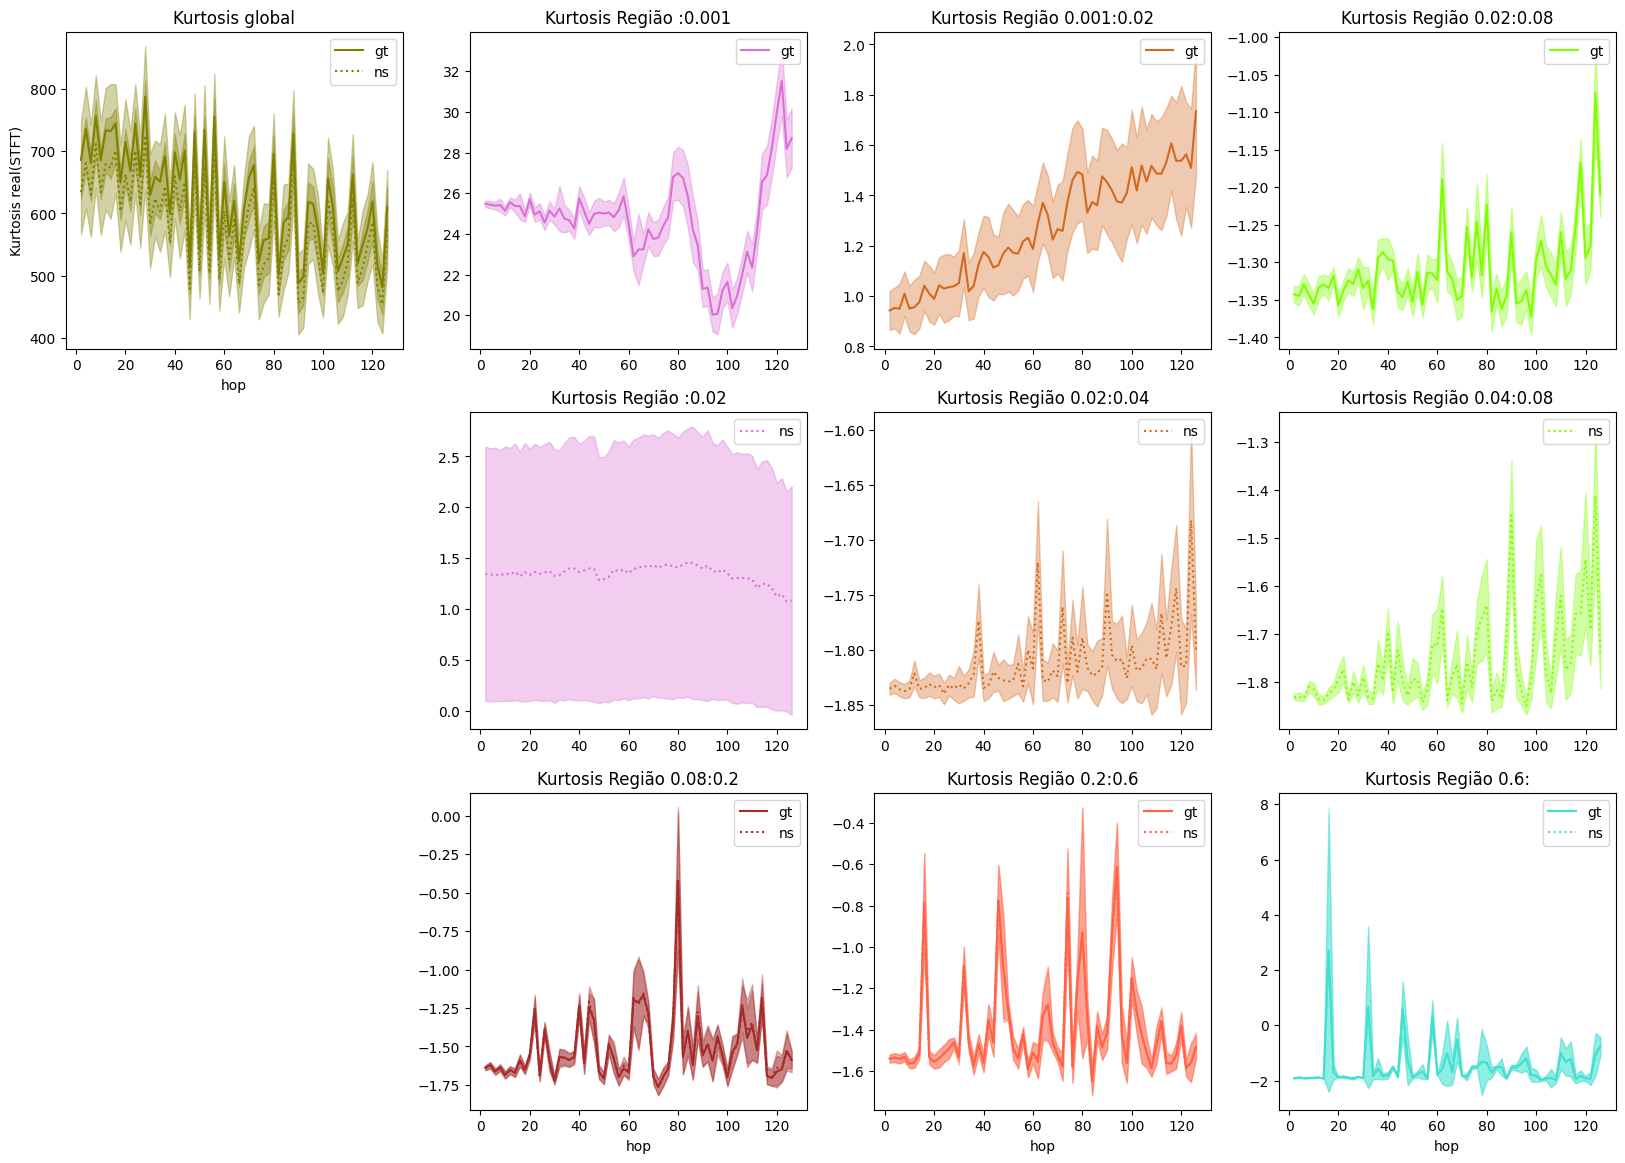

In [43]:
colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']
stat_name = 'kurtosis'

fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1])
axdiv = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3]),
         fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3]),
         fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[2, 3]),fig.add_subplot(gs[1, 0])]


aux = np.array(gt_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(gt_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='gt')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
aux = np.array(ns_metrics['stats_global'][stat_name]['mean'])
aux_std = np.array(ns_metrics['stats_global'][stat_name]['std'])
axdiv[0].plot(hop_,aux,color='olive',label='ns',linestyle='dotted')
axdiv[0].fill_between(hop_, aux - aux_std, 
                   aux + aux_std, alpha=0.35, color = 'olive')
axdiv[0].set_title('Kurtosis global')
axdiv[0].legend(loc='upper right')
axdiv[0].set_xlabel('hop')
axdiv[0].set_ylabel('Kurtosis real(STFT)')

for i in range(3):
        aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[i+1].plot(hop_,aux,color=colors[i],label='gt')
        axdiv[i+1].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[i+1].set_title('Kurtosis Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[1+i].legend(loc='upper right')
        aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
        aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
        axdiv[4+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
        axdiv[4+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        axdiv[4+i].set_title('Kurtosis Região '+list(ns_metrics['stats_per_region'][stat_name].keys())[i])
        axdiv[4+i].legend(loc='upper right')

for i in range(3,len(list(ns_metrics['stats_per_region'][stat_name].keys()))):
    aux = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(gt_metrics['stats_per_region'][stat_name][list(gt_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[i+5].plot(hop_,aux,color=colors[i],label='gt')
    axdiv[i+5].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    aux = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['mean'])
    aux_std = np.array(ns_metrics['stats_per_region'][stat_name][list(ns_metrics['stats_per_region'][stat_name].keys())[i]]['std'])
    axdiv[5+i].plot(hop_,aux,color=colors[i],label='ns',linestyle='dotted')
    axdiv[5+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    axdiv[i+5].set_title('Kurtosis Região '+list(gt_metrics['stats_per_region'][stat_name].keys())[i])
    axdiv[5+i].set_xlabel('hop')
    axdiv[5+i].legend(loc='upper right')
    
axdiv[7].axis('off')
axdiv[-1].axis('off')
plt.tight_layout
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_kurtosis.png')

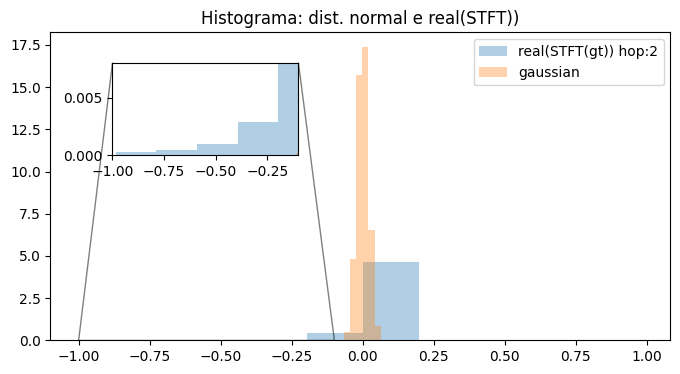

In [44]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

data = np.random.normal(0, 0.020, spgram_hop_gt['hop_'+str(hop_[0])][0].flatten().shape[0])
plt.hist(np.real(spgram_hop_gt['hop_'+str(hop_[0])][0]).flatten(),density=True,alpha=0.35,label='real(STFT(gt)) hop:'+str(hop_[0]))
plt.hist(data,density=True,alpha=0.35,label='gaussian')
axins = ax.inset_axes([0.1, 0.6, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.008))
ax.indicate_inset_zoom(axins, edgecolor="black")

axins.hist(np.real(spgram_hop_gt['hop_'+str(hop_[0])][0]).flatten(),density=True,alpha=0.35,label='hop:'+str(hop_[0]))
axins.hist(data,density=True,alpha=0.35,label='gaussian')
plt.title('Histograma: dist. normal e real(STFT))')
plt.legend(loc='upper right')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_normal_x_spect.png')

-0.0016071340832963799
-0.023148937269881653
-0.23690778656467248
-1.0315086362255212
-1.4071571429561531


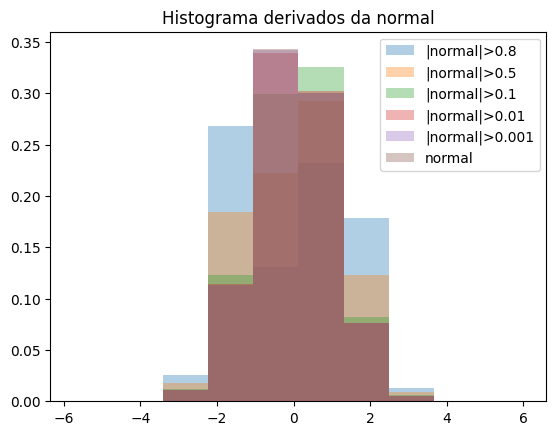

In [45]:
data = np.random.normal(0, 1, spgram_hop_gt['hop_'+str(hop_[0])][0].flatten().shape[0])
data_aux1 = data[np.abs(data) > 0.001]
print(stats.kurtosis(data_aux1))
data_aux2 = data[np.abs(data) > 0.01]
print(stats.kurtosis(data_aux2))
data_aux3 = data[np.abs(data) > 0.1]
print(stats.kurtosis(data_aux3))
data_aux4 = data[np.abs(data) > 0.5]
print(stats.kurtosis(data_aux4))
data_aux5 = data[np.abs(data) > 0.8]
print(stats.kurtosis(data_aux5))
plt.hist(data_aux5,density=True,alpha=0.35,label='|normal|>0.8')
plt.hist(data_aux4,density=True,alpha=0.35,label='|normal|>0.5')
plt.hist(data_aux3,density=True,alpha=0.35,label='|normal|>0.1')
plt.hist(data_aux2,density=True,alpha=0.35,label='|normal|>0.01')
plt.hist(data_aux1,density=True,alpha=0.35,label='|normal|>0.001')
plt.hist(data,density=True,alpha=0.35,label='normal')
plt.title('Histograma derivados da normal')
plt.legend(loc='upper right')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_diffs_normal_kurt.png')